## 02. Descriptive

In [80]:
# Standard libraries - run pip install if necessary
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gp
import folium
from matplotlib.patches import FancyArrowPatch
import matplotlib.colors as mcolors
import matplotlib

In [2]:
df_taxidata = pd.read_parquet('data/prepped/prep_taxidata.parquet')
df_taxidata.head()

trip_id  \
0  4404c6835b9e74e9f74d70f235200a8ce09db14a   
2  3f5cd3f78e5cab455606a31372a95d3204b2fb3f   
3  38292159642750da7b20419330566f9eb0961cde   
4  3e01498f8ff771ad7eb37e4844cef20201b6c339   
5  3c5c3b39099216b5789fe007c0fcdebd7e50ed7d   

                                             taxi_id trip_start_timestamp  \
0  7e179f8ef66ae99ec2d1ec89224e0b7ee5469fe5627f6d...  2022-12-31 23:45:00   
2  847cf962bd6f62040673e6c24c24940aeb2d7fdaa54677...  2022-12-31 23:45:00   
3  81092e4881f56106fae845c3ae4492f8b3c3213c33c920...  2022-12-31 23:45:00   
4  4ae32e2eb244ce143800e0c40055e537cc50e3358a07ce...  2022-12-31 23:45:00   
5  75cf3a53aae5e5858361a7ca64f75d3407dc0a44d7bc42...  2022-12-31 23:45:00   

   trip_end_timestamp  trip_seconds  trip_miles  pickup_census_tract  \
0 2023-01-01 00:15:00        2081.0        4.42                  NaN   
2 2023-01-01 00:00:00         600.0        0.90                  NaN   
3 2023-01-01 00:00:00         546.0        0.85                  NaN   
4 2023-01-01 00:00:00         574.0        0.33                  NaN   
5 2023-01-01 00:00:00        1018.0        6.12                  NaN   

   dropoff_census_tract   fare  tips  ...  company_encoded  taxi_id_encoded  \
0                   NaN  20.50   0.0  ...                0                0   
2                   NaN   7.00   2.0  ...                1                1   
3                   NaN   6.50   0.0  ...                2                2   
4                   NaN   6.25   0.0  ...                3                3   
5                   NaN  18.25   0.0  ...                3                4   

   pickup_community pickup_area_number dropoff_community  dropoff_area_number  \
0        WEST RIDGE                  2            UPTOWN                    3   
2   NEAR NORTH SIDE                  8   NEAR NORTH SIDE                    8   
3   NEAR NORTH SIDE                  8   NEAR NORTH SIDE                    8   
4   NEAR NORTH SIDE                  8   NEAR NORTH SIDE                    8   
5    AUBURN GRESHAM                 71       SOUTH SHORE                   43   

    h3_res7_pickup  h3_res7_dropoff   h3_res8_pickup  h3_res8_dropoff  
0  872664d8effffff  872664d89ffffff  882664d8e1fffff  882664d897fffff  
2  872664c1effffff  872664c1effffff  882664c1edfffff  882664c1edfffff  
3  872664c1effffff  872664c1effffff  882664c1edfffff  882664c1edfffff  
4  872664c1effffff  872664c1effffff  882664c1edfffff  882664c1edfffff  
5  872664cd8ffffff  872664ceaffffff  882664cd89fffff  882664cea7fffff  

[5 rows x 45 columns]

In [3]:
df_taxidata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4739665 entries, 0 to 6382424
Data columns (total 45 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   trip_id                     object        
 1   taxi_id                     object        
 2   trip_start_timestamp        datetime64[ns]
 3   trip_end_timestamp          datetime64[ns]
 4   trip_seconds                float64       
 5   trip_miles                  float64       
 6   pickup_census_tract         float64       
 7   dropoff_census_tract        float64       
 8   fare                        float64       
 9   tips                        float64       
 10  tolls                       float64       
 11  extras                      float64       
 12  trip_total                  float64       
 13  payment_type                object        
 14  company                     object        
 15  pickup_centroid_latitude    float64       
 16  pickup_centroid_longitu

In [4]:
df_censusTrack = gp.read_file('data/prepped/census_tracts_df.geojson')

In [5]:
df_censusTrack.head()

commarea      geoid10                                           geometry
0       44  17031842400  MULTIPOLYGON (((-87.62405 41.73022, -87.62405 ...
1       59  17031840300  MULTIPOLYGON (((-87.68608 41.82296, -87.68607 ...
2       34  17031841100  MULTIPOLYGON (((-87.62935 41.85280, -87.62934 ...
3       31  17031841200  MULTIPOLYGON (((-87.68813 41.85569, -87.68816 ...
4       32  17031839000  MULTIPOLYGON (((-87.63312 41.87449, -87.63306 ...

### Number of pickups and dropoffs in each community area

In [6]:
df_taxidata['number_of_trips_pickup'] = 0
df_taxidata['number_of_trips_dropoff'] = 0
community_counts_pickup = df_taxidata.groupby(['pickup_community', 'pickup_area_number'])['number_of_trips_pickup'].count().reset_index()
community_counts_dropoff = df_taxidata.groupby(['dropoff_community', 'dropoff_area_number'])['number_of_trips_dropoff'].count().reset_index()

In [7]:
df_censusTrack.rename(columns = {'commarea':'pickup_area_number'}, inplace = True)
dfmerged_community_counts_pickup = community_counts_pickup.merge(df_censusTrack, how='left', on='pickup_area_number')

df_censusTrack.rename(columns = {'pickup_area_number':'dropoff_area_number'}, inplace = True)
dfmerged_community_counts_dropoff = community_counts_dropoff.merge(df_censusTrack, how='left', on='dropoff_area_number')

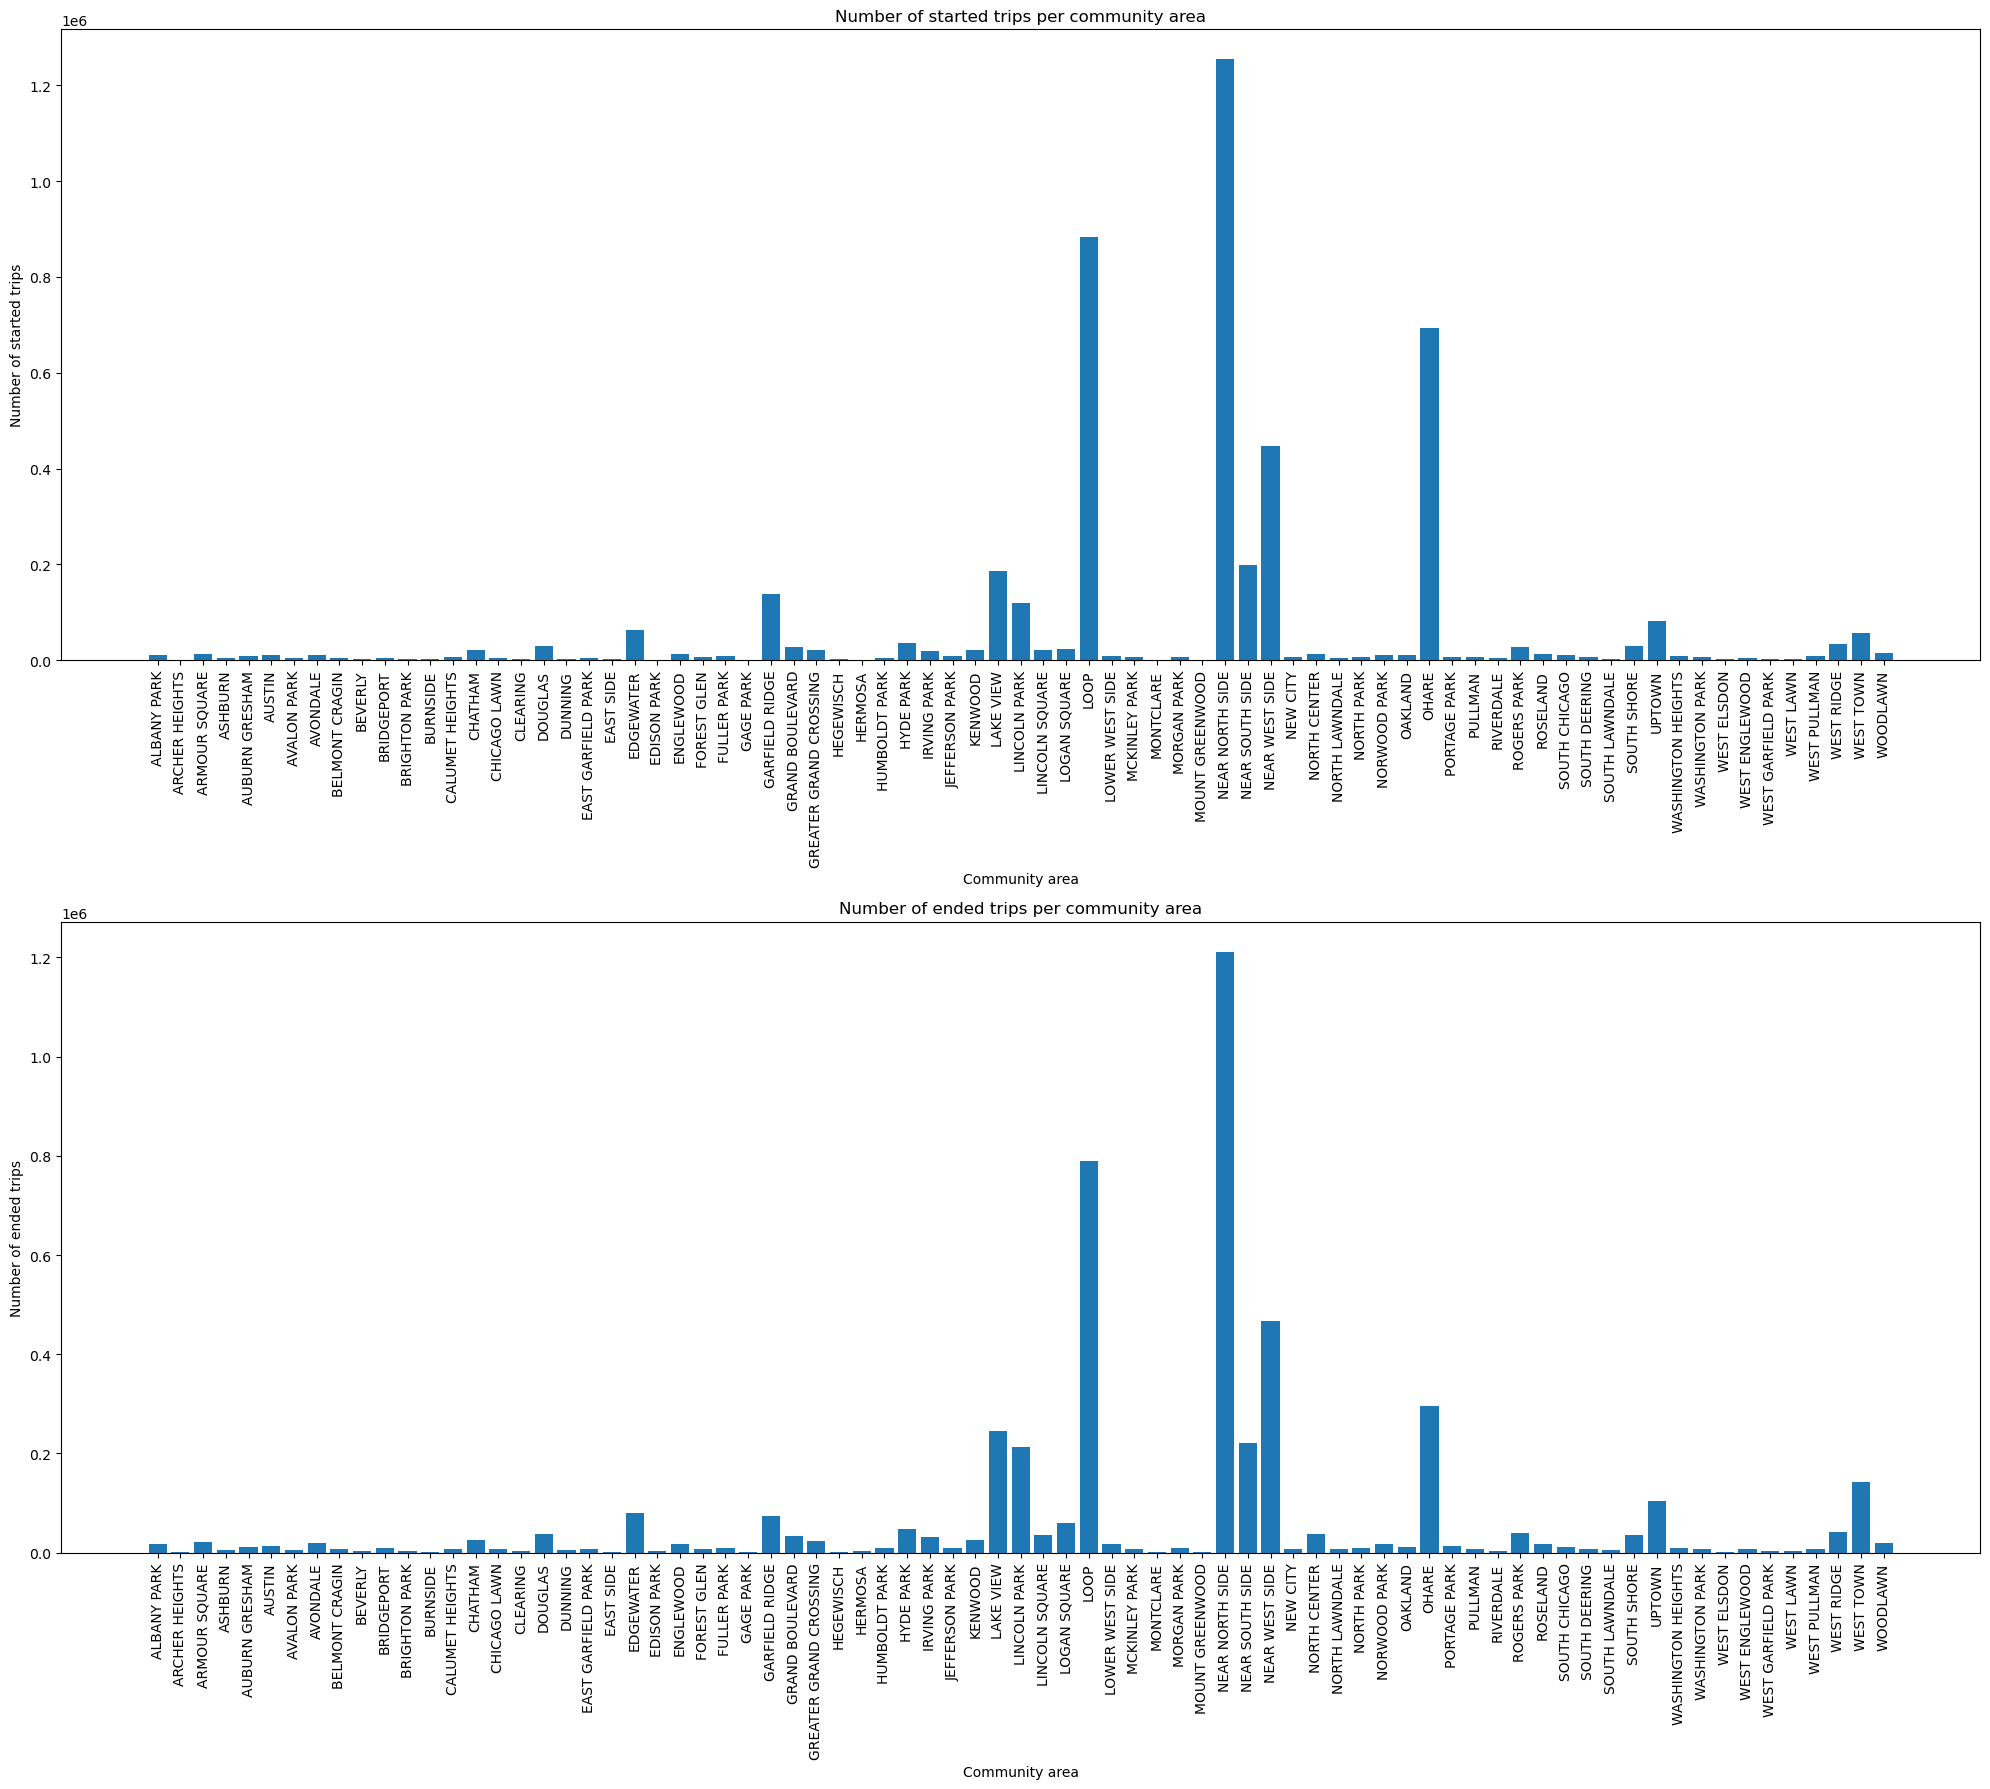

In [8]:
plt.figure(figsize=(20, 18))

# First subplot (pickup)
plt.subplot(2, 1, 1)
plt.bar(community_counts_pickup['pickup_community'], community_counts_pickup['number_of_trips_pickup'])
plt.title('Number of started trips per community area')
plt.xlabel('Community area')
plt.ylabel('Number of started trips')
plt.xticks(rotation=90)

# Second subplot (dropoff)
plt.subplot(2, 1, 2)
plt.bar(community_counts_dropoff['dropoff_community'], community_counts_dropoff['number_of_trips_dropoff'])
plt.title('Number of ended trips per community area')
plt.xlabel('Community area')
plt.ylabel('Number of ended trips')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

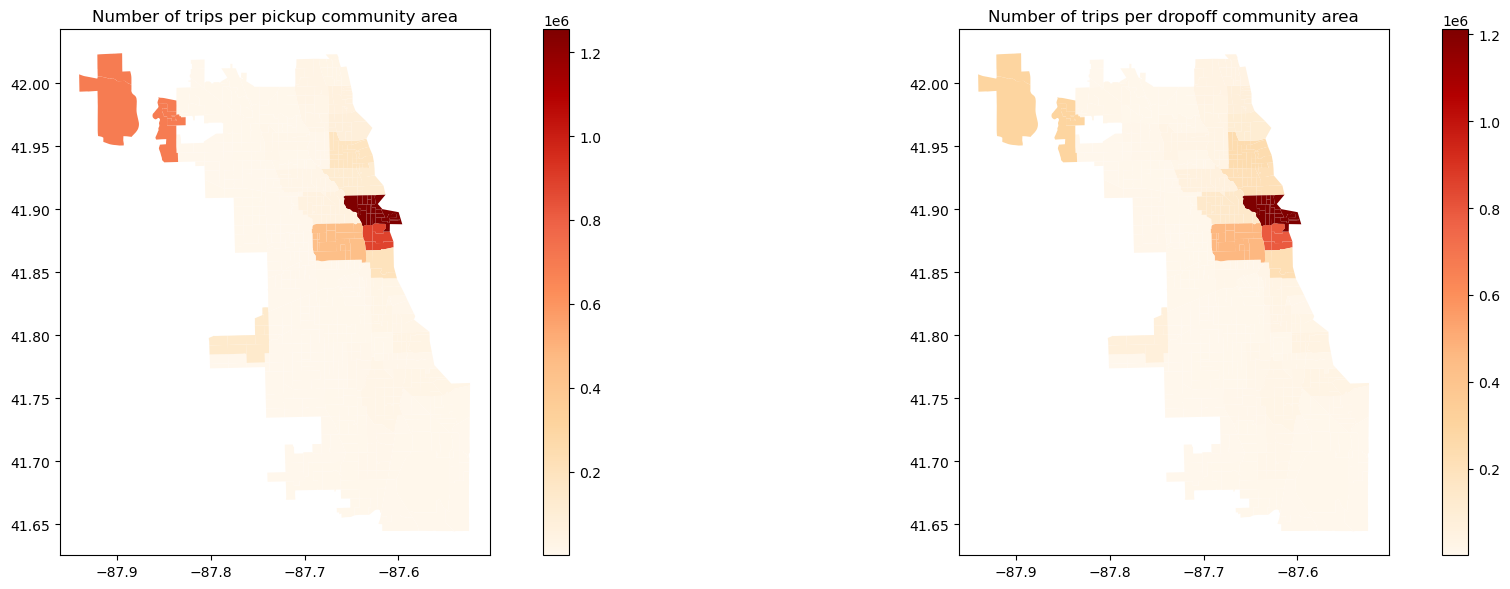

In [9]:
community_counts_pickup_geo = gp.GeoDataFrame(dfmerged_community_counts_pickup, geometry=dfmerged_community_counts_pickup['geometry'], crs='EPSG:4326')
community_counts_dropoff_geo = gp.GeoDataFrame(dfmerged_community_counts_dropoff, geometry=dfmerged_community_counts_dropoff['geometry'], crs='EPSG:4326')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))  # 1 row, 2 columns

# First map plot (pickup)
community_counts_pickup_geo.plot(column="number_of_trips_pickup", legend=True, cmap='OrRd', ax=axes[0])
axes[0].set_title('Number of trips per pickup community area')

# Second map plot (dropoff)
community_counts_dropoff_geo.plot(column="number_of_trips_dropoff", legend=True, cmap = 'OrRd', ax=axes[1])
axes[1].set_title('Number of trips per dropoff community area')

plt.tight_layout()
plt.show()

In the first graph you can see that there are some community areas where the most trips started and in the second graph you can see that there are also specific areas where the most trips ended. These areas are very similar, like the most rips start and end in the same areas. We identify the top 4 areas for pickup and for dropoff in the next step:

In [10]:
#sort pickup areas
pickup_trips = community_counts_pickup.sort_values('number_of_trips_pickup', ascending=False)
pickup_toptrips= community_counts_pickup.head(4)

#sort dropoff areas
dropoff_trips = community_counts_dropoff.sort_values('number_of_trips_dropoff', ascending=False)
dropoff_toptrips = community_counts_dropoff.head(4)

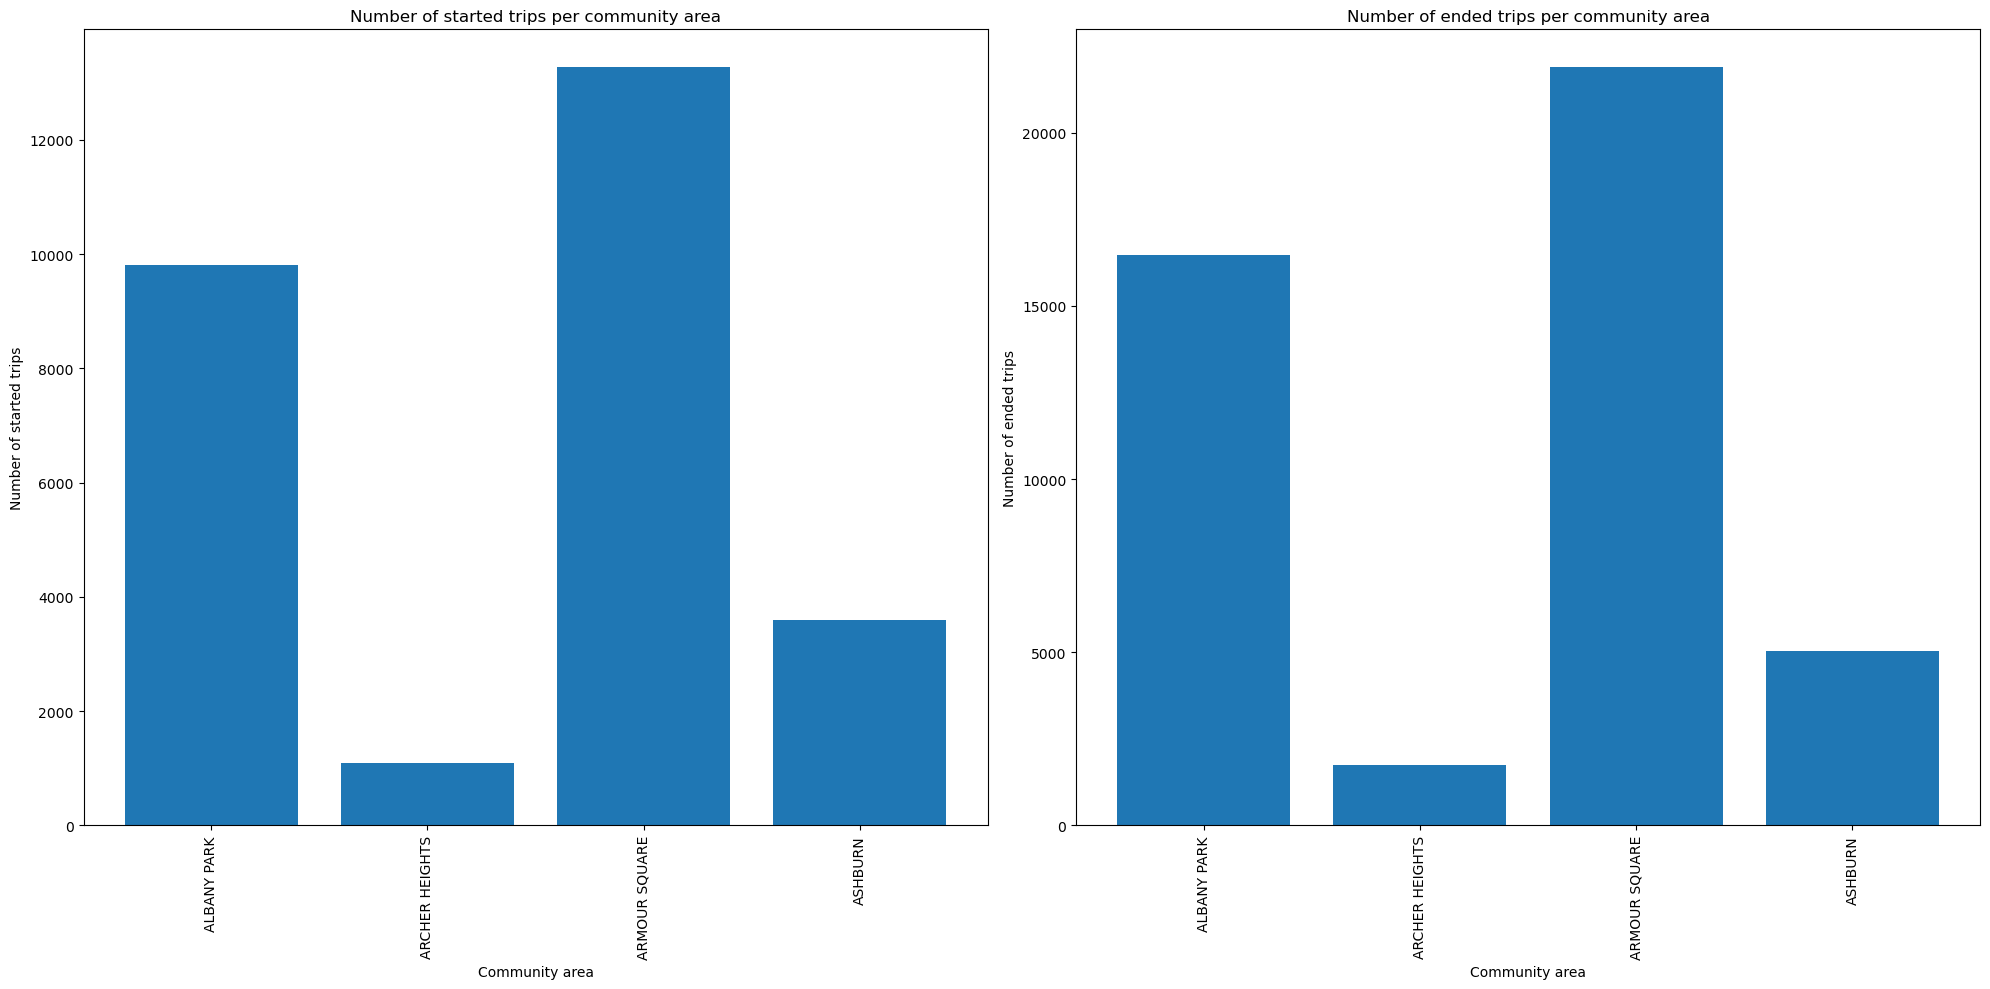

In [11]:
plt.figure(figsize=(20, 10))

#Plot top 10 pickup areas
plt.subplot(1, 2, 1)
plt.bar(pickup_toptrips['pickup_community'], pickup_toptrips['number_of_trips_pickup'])
plt.title('Number of started trips per community area')
plt.xlabel('Community area')
plt.ylabel('Number of started trips')
plt.xticks(rotation=90)

#plot top 10 dropoff areas
plt.subplot(1, 2, 2)
plt.bar(dropoff_toptrips['dropoff_community'], dropoff_toptrips['number_of_trips_dropoff'])
plt.title('Number of ended trips per community area')
plt.xlabel('Community area')
plt.ylabel('Number of ended trips')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

Here we can see that the number for pickup and dropoff is highest in the same community areas and are also similar in value

### Start time in each community area

In [12]:
df_taxidata_startTime = df_taxidata
df_taxidata_startTime['number_of_trips_start_hour'] = 0
df_taxidata_startTime = df_taxidata.groupby(['pickup_community', 'pickup_area_number', '1_hour_window'])['number_of_trips_start_hour'].count().reset_index()

idx = df_taxidata_startTime.groupby(['pickup_community', 'pickup_area_number'])['number_of_trips_start_hour'].idxmax()
df_most_trips = df_taxidata_startTime.loc[idx].reset_index()
df_most_trips = df_most_trips.drop('index', axis=1)

In [13]:
df_censusTrack.rename(columns = {'dropoff_area_number':'pickup_area_number'}, inplace = True)
df_merged_start_hour_trips = df_most_trips.merge(df_censusTrack, how='left', on='pickup_area_number')
df_merged_start_hour_trips = df_merged_start_hour_trips.sort_values(['1_hour_window']).reset_index()

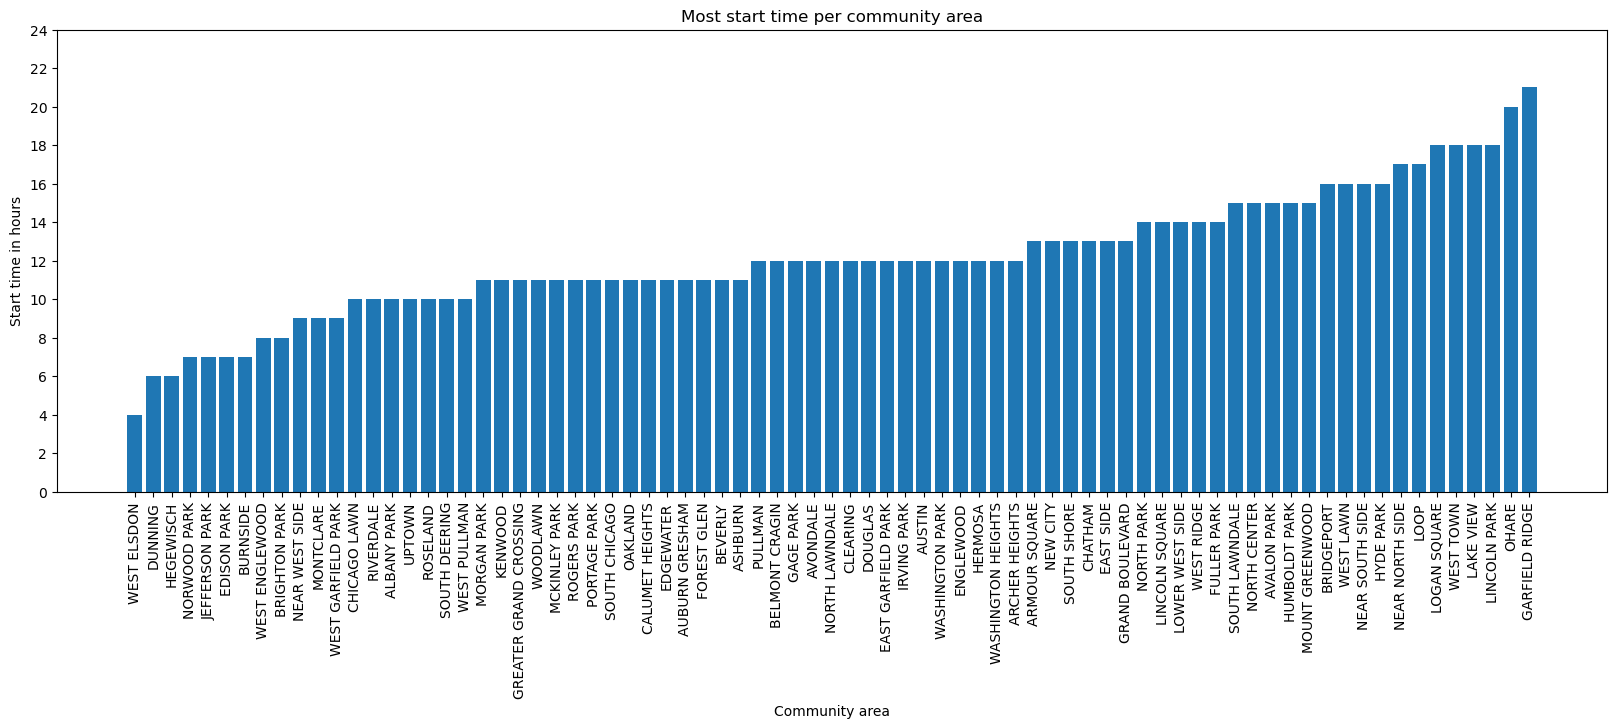

In [14]:
plt.figure(figsize=(20,6))
plt.bar(df_merged_start_hour_trips['pickup_community'], df_merged_start_hour_trips['1_hour_window'])
plt.title('Most start time per community area')
plt.xlabel('Community area')
plt.ylabel('Start time in hours')
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 26, 2))
plt.show()

As you can see, the most common times at which journeys start within the various community areas are between 10am and 2pm

<Figure size 2000x600 with 0 Axes>

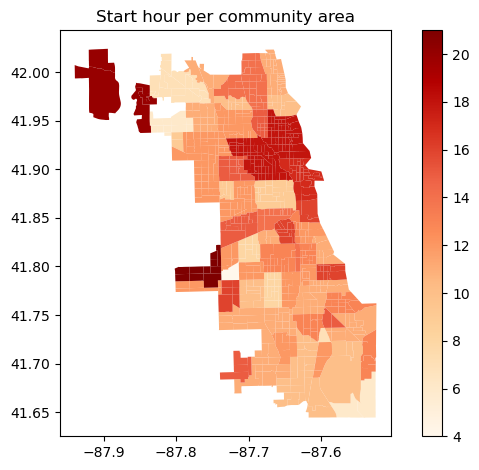

In [15]:
df_merged_start_hour_trips_geo = gp.GeoDataFrame(df_merged_start_hour_trips, geometry=df_merged_start_hour_trips['geometry'], crs='EPSG:4326')
plt.figure(figsize=(20,6))
df_merged_start_hour_trips_geo.plot(column="1_hour_window", legend=True, cmap = 'OrRd')
plt.title('Start hour per community area')

plt.tight_layout()
plt.show()

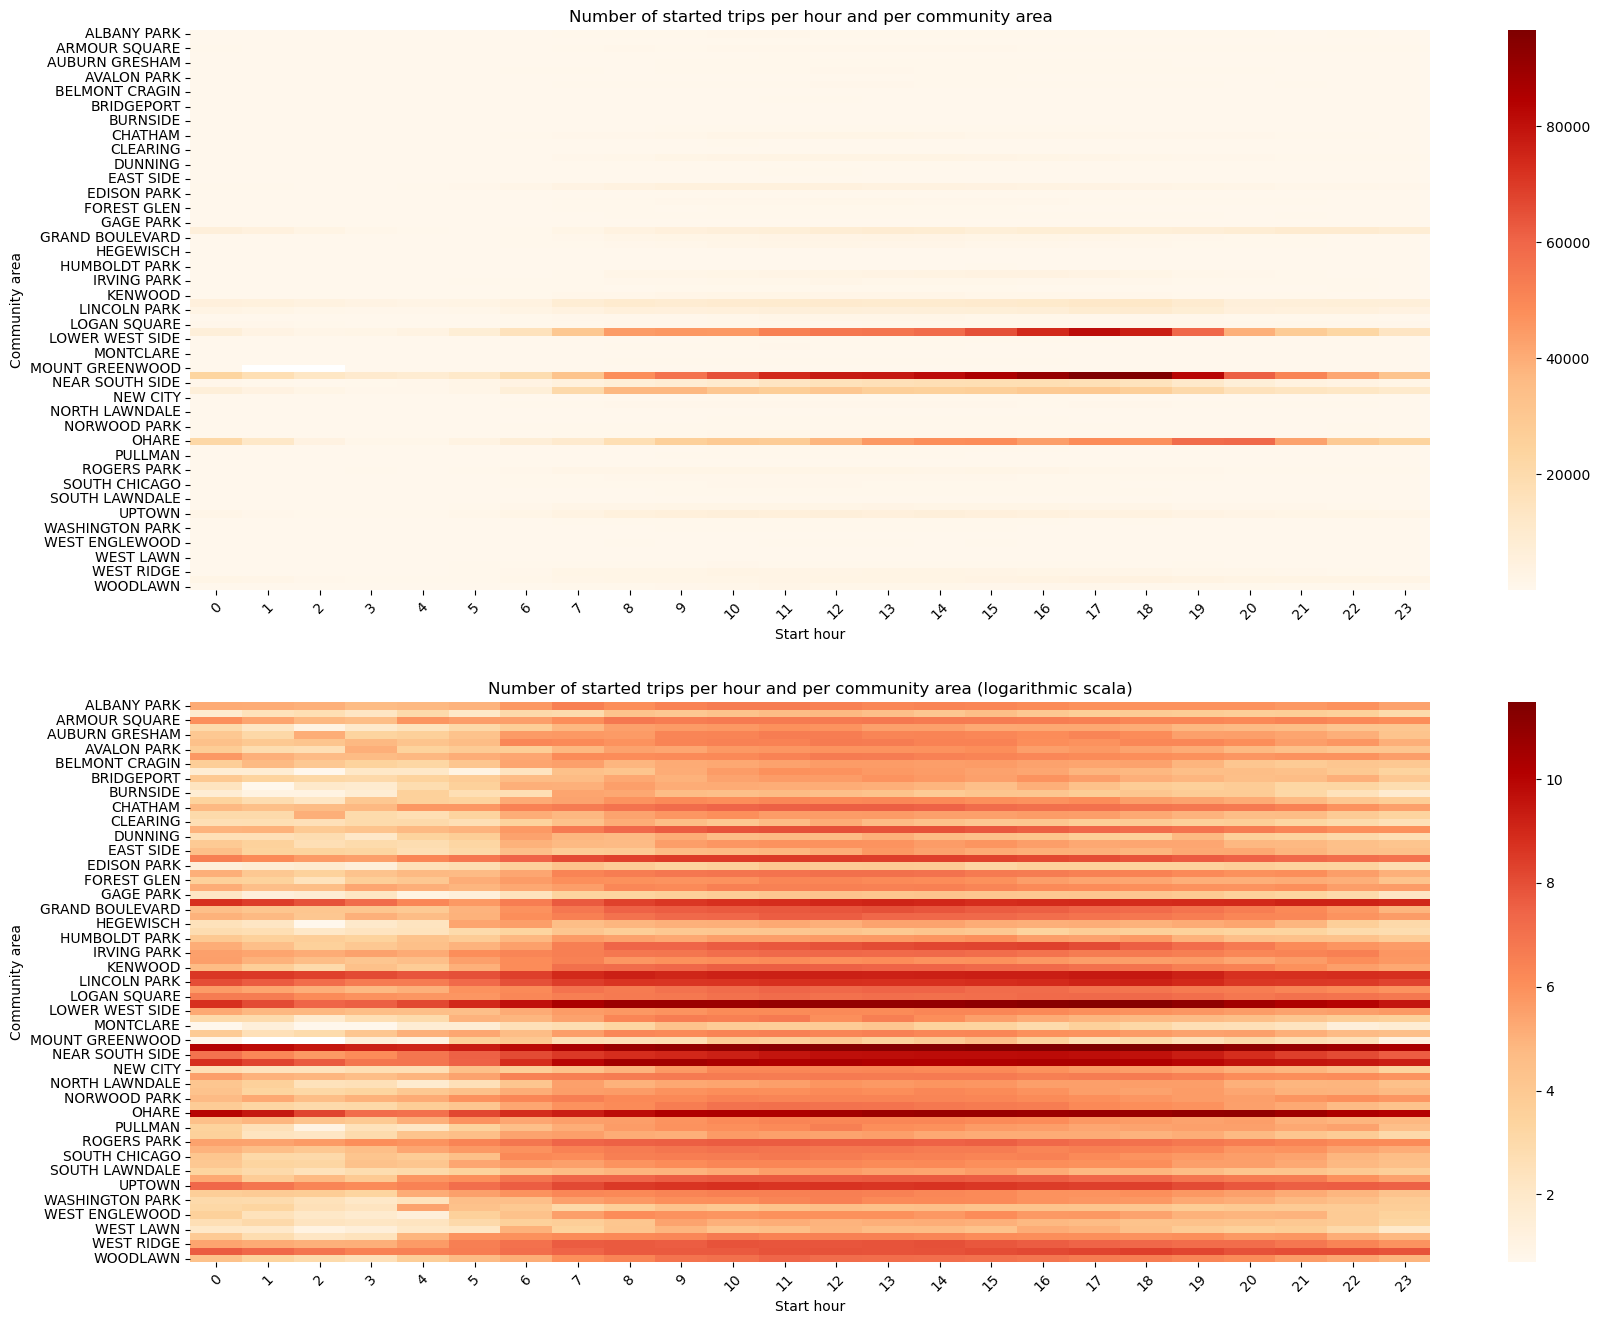

In [16]:
#Number of started trips per hour and per community area
df_taxidata_startTime
pivot_table_startTime = df_taxidata_startTime.pivot_table(index="pickup_community", columns="1_hour_window", values="number_of_trips_start_hour")
log_pivot_table_startTime = np.log1p(pivot_table_startTime)

plt.figure(figsize=(20,16))

plt.subplot(2, 1, 1)
sns.heatmap(pivot_table_startTime, cmap='OrRd')
plt.title('Number of started trips per hour and per community area')
plt.xlabel('Start hour')
plt.ylabel('Community area')
plt.xticks(rotation=45)

plt.subplot(2, 1, 2)
sns.heatmap(log_pivot_table_startTime, cmap='OrRd')
plt.title('Number of started trips per hour and per community area (logarithmic scala)')
plt.xlabel('Start hour')
plt.ylabel('Community area')
plt.xticks(rotation=45)

plt.show()


The upper of the two diagrams shows that there is a small number of community areas with the highest number of started trips, which is clearly above the others. The lower diagram with the logarithmic scale shows more precisely the times at which most trips start for each area. Here you can see that, as already suspected, the fewest trips start between midnight and 5am.

To have a better insight, we also look at these diagrams for the 4-hour and the 6-hour window.

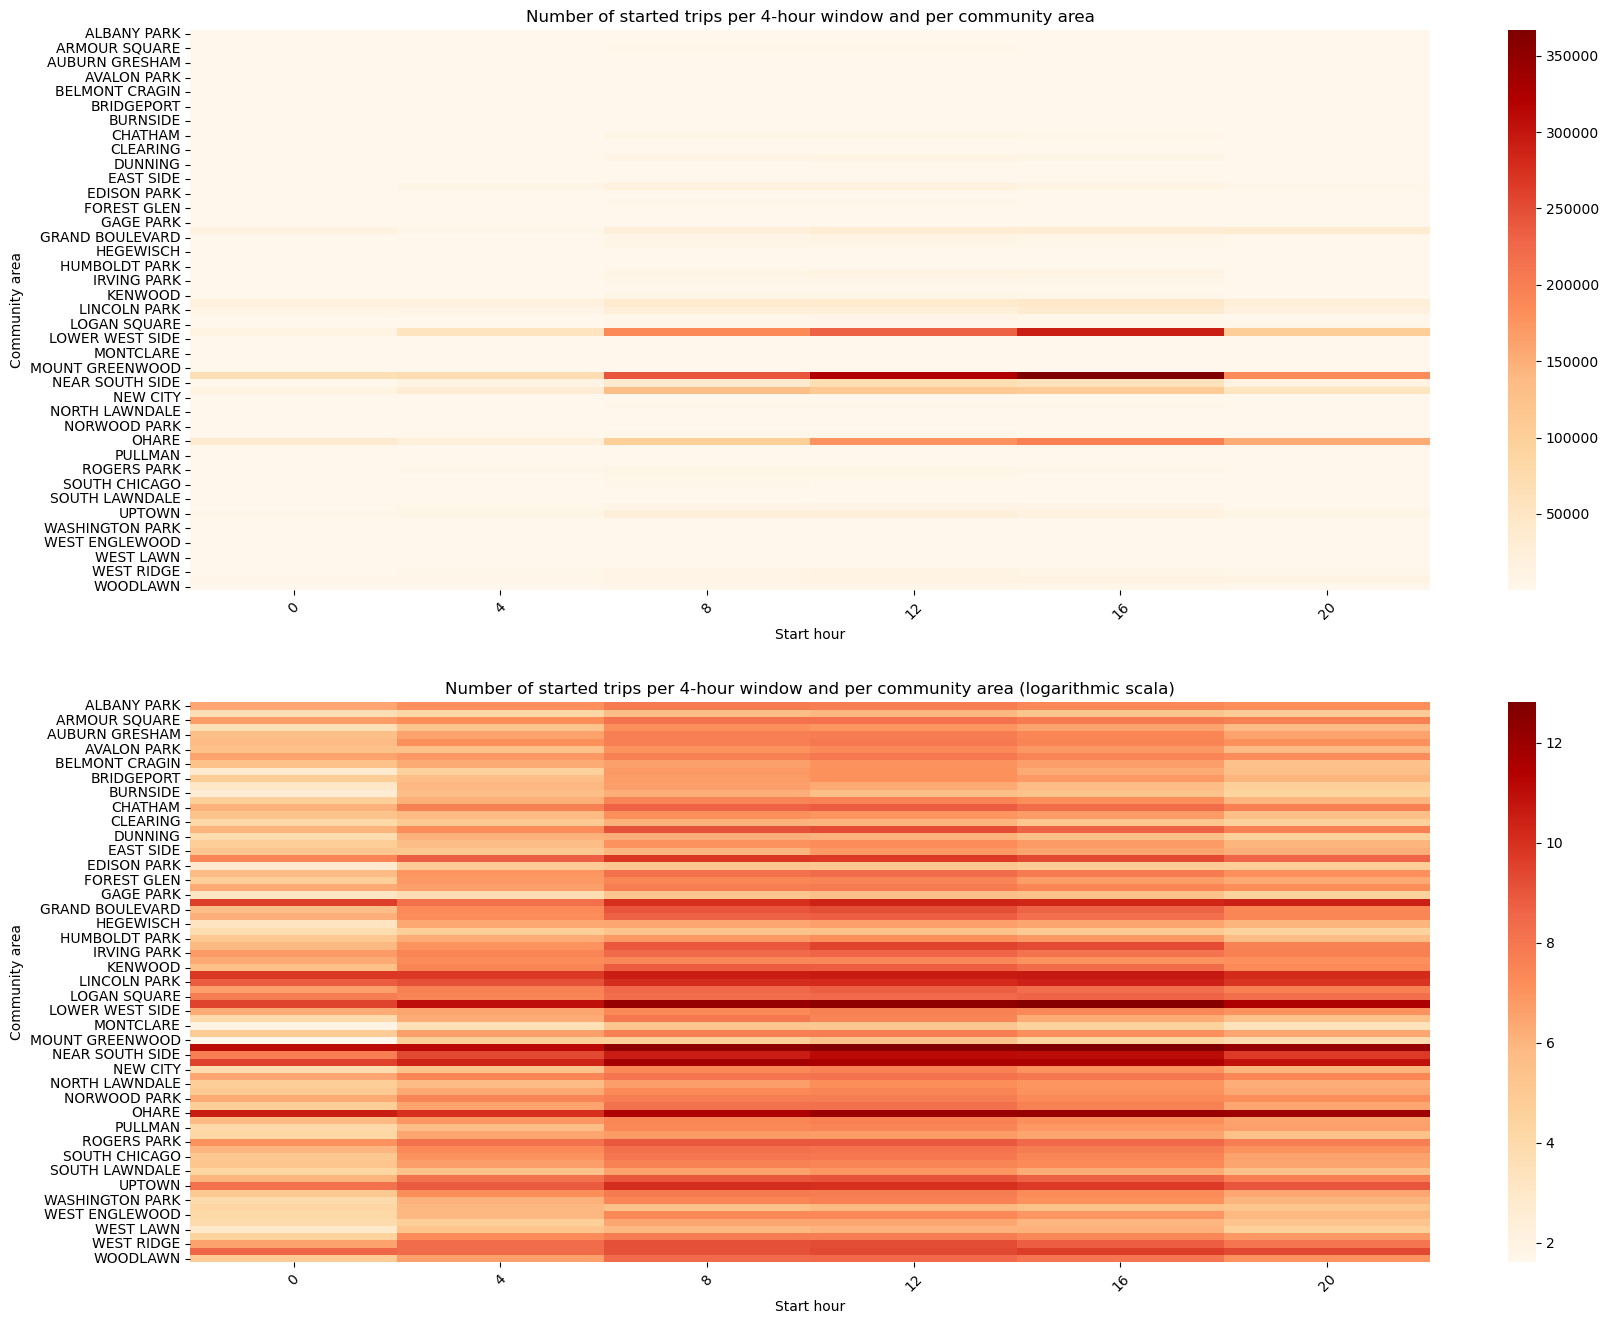

In [17]:
# 4-hour window
df_taxidata_startTime_fourWindow = df_taxidata
df_taxidata_startTime_fourWindow['number_of_trips_start_hour'] = 0
df_taxidata_startTime_fourWindow = df_taxidata.groupby(['pickup_community', 'pickup_area_number', '4_hour_window'])['number_of_trips_start_hour'].count().reset_index()

pivot_table_startTime_fourWindow = df_taxidata_startTime_fourWindow.pivot_table(index="pickup_community", columns="4_hour_window", values="number_of_trips_start_hour")
log_pivot_table_startTime_fourWindow = np.log1p(pivot_table_startTime_fourWindow)

plt.figure(figsize=(20,16))

plt.subplot(2, 1, 1)
sns.heatmap(pivot_table_startTime_fourWindow, cmap='OrRd')
plt.title('Number of started trips per 4-hour window and per community area')
plt.xlabel('Start hour')
plt.ylabel('Community area')
plt.xticks(rotation=45)

plt.subplot(2, 1, 2)
sns.heatmap(log_pivot_table_startTime_fourWindow, cmap='OrRd')
plt.title('Number of started trips per 4-hour window and per community area (logarithmic scala)')
plt.xlabel('Start hour')
plt.ylabel('Community area')
plt.xticks(rotation=45)

plt.show()

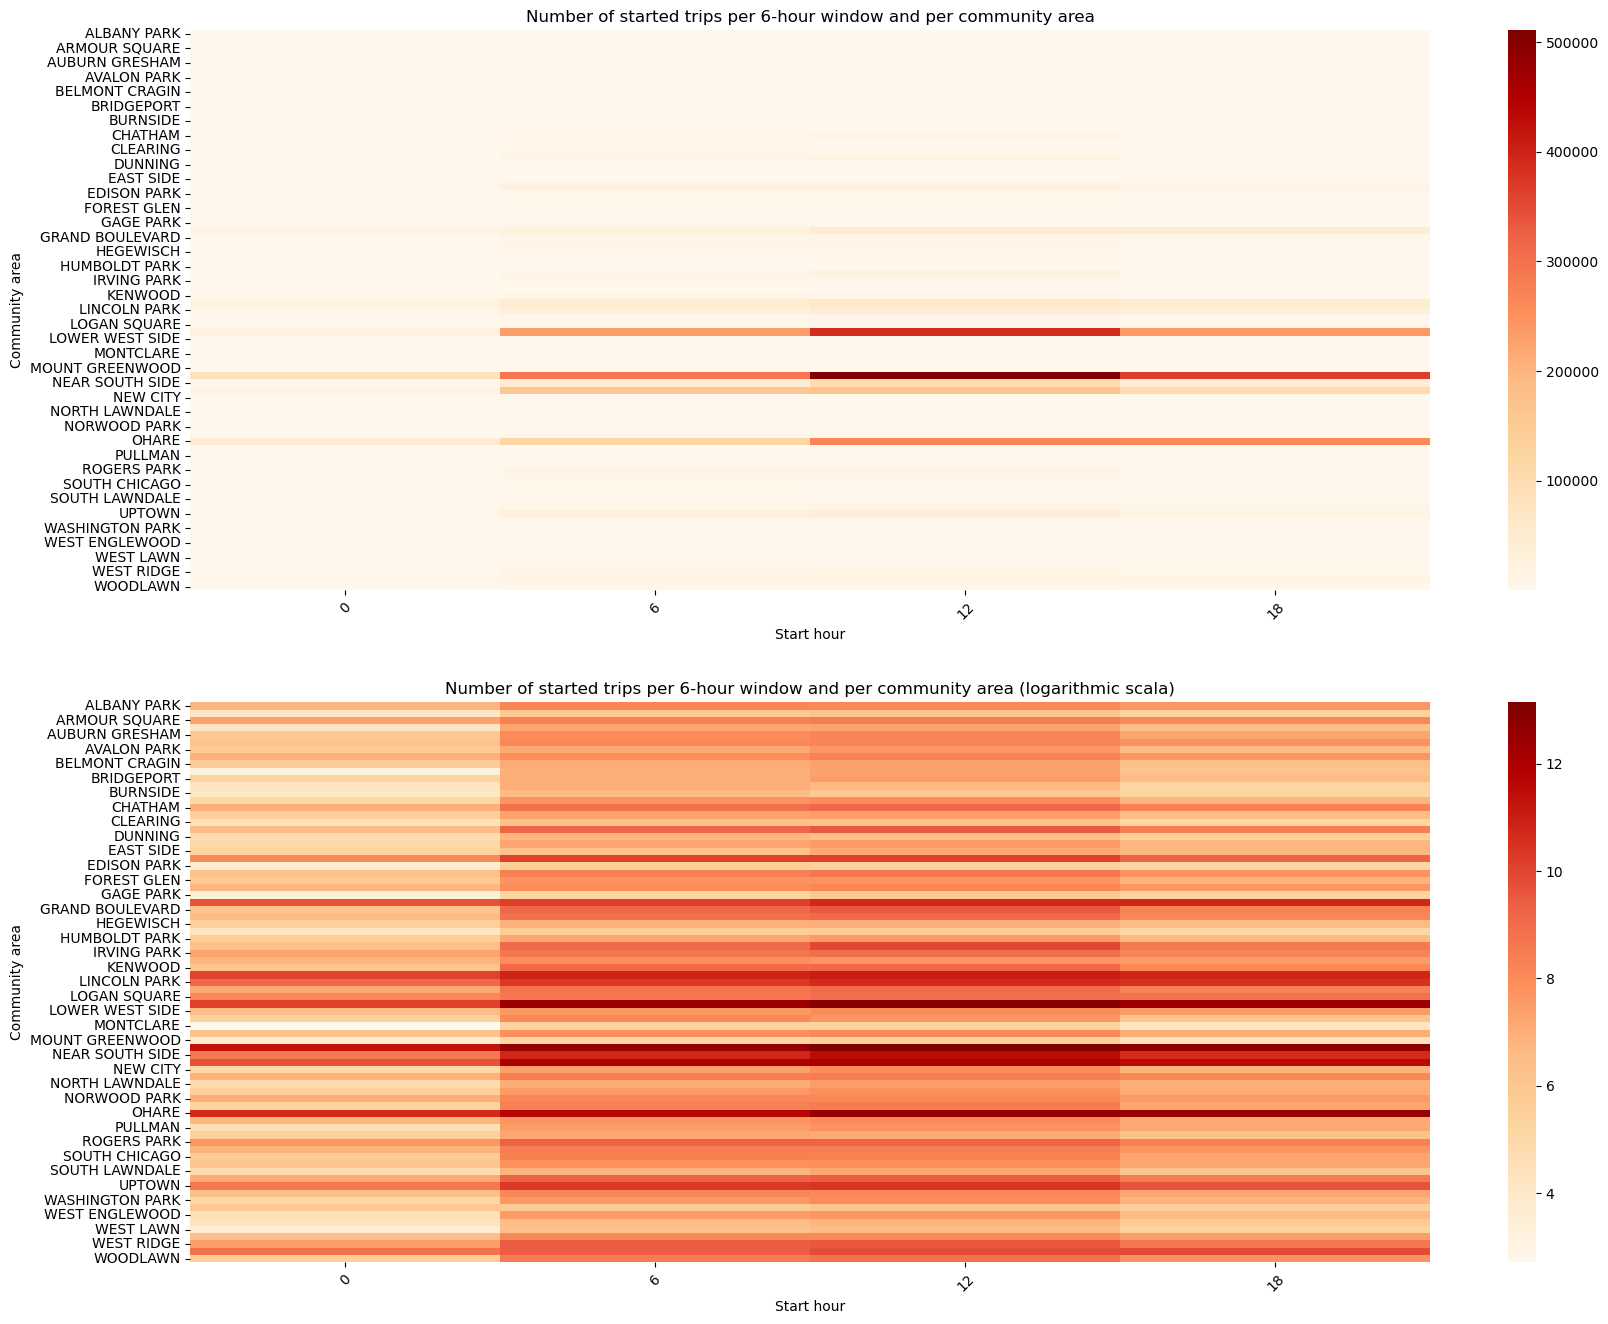

In [18]:
# 6-hour window
df_taxidata_startTime_sixWindow = df_taxidata
df_taxidata_startTime_sixWindow['number_of_trips_start_hour'] = 0
df_taxidata_startTime_sixWindow = df_taxidata.groupby(['pickup_community', 'pickup_area_number', '6_hour_window'])['number_of_trips_start_hour'].count().reset_index()

pivot_table_startTime_sixWindow = df_taxidata_startTime_sixWindow.pivot_table(index="pickup_community", columns="6_hour_window", values="number_of_trips_start_hour")
log_pivot_table_startTime_sixWindow = np.log1p(pivot_table_startTime_sixWindow)

plt.figure(figsize=(20,16))

plt.subplot(2, 1, 1)
sns.heatmap(pivot_table_startTime_sixWindow, cmap='OrRd')
plt.title('Number of started trips per 6-hour window and per community area')
plt.xlabel('Start hour')
plt.ylabel('Community area')
plt.xticks(rotation=45)

plt.subplot(2, 1, 2)
sns.heatmap(log_pivot_table_startTime_sixWindow, cmap='OrRd')
plt.title('Number of started trips per 6-hour window and per community area (logarithmic scala)')
plt.xlabel('Start hour')
plt.ylabel('Community area')
plt.xticks(rotation=45)

plt.show()

You can see from these diagrams that most trips start between 8am and 12pm and then the earlier or the later it gets and the further we deviate from this time window, the number of trips decreases significantly. The number of trips started is significantly lower, especially at night and in the evening.

### Number of started trips for each start day and start hour

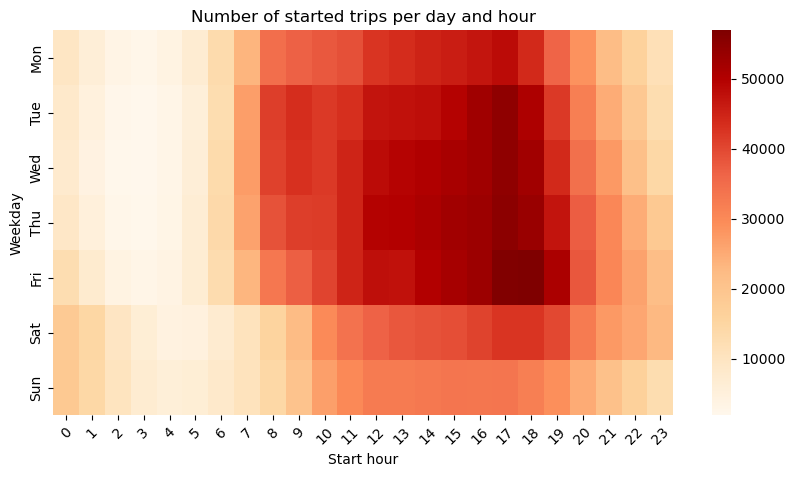

In [19]:
df_taxidata_startDayHour = df_taxidata
df_taxidata_startDayHour['number_of_trips_start_hour_day'] = 0
df_taxidata_startDayHour = df_taxidata.groupby(['weekday', '1_hour_window'])['number_of_trips_start_hour_day'].count().reset_index()

pivot_table_startDayHour = df_taxidata_startDayHour.pivot_table(index="weekday", columns="1_hour_window", values="number_of_trips_start_hour_day")

plt.figure(figsize=(10,5))
custom_y_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
sns.heatmap(pivot_table_startDayHour, cmap='OrRd', yticklabels = custom_y_labels)
plt.title('Number of started trips per day and hour')
plt.xlabel('Start hour')
plt.ylabel('Weekday')
plt.xticks(rotation=45)

plt.show()

If we compare the number of trips started per weekday and per hour, we can see the following from the heat map:
- More trips during the week than at the weekend
- Time window shifted slightly backwards at the weekend
- During the week, trips mainly start between 8 am and 6 pm 
- At the weekend, trips mainly start between 10 a.m. and 7 p.m.
- Peak time is generally Tuesday to Friday between 4 and 6 pm

### Number of started trips for each start day and community area

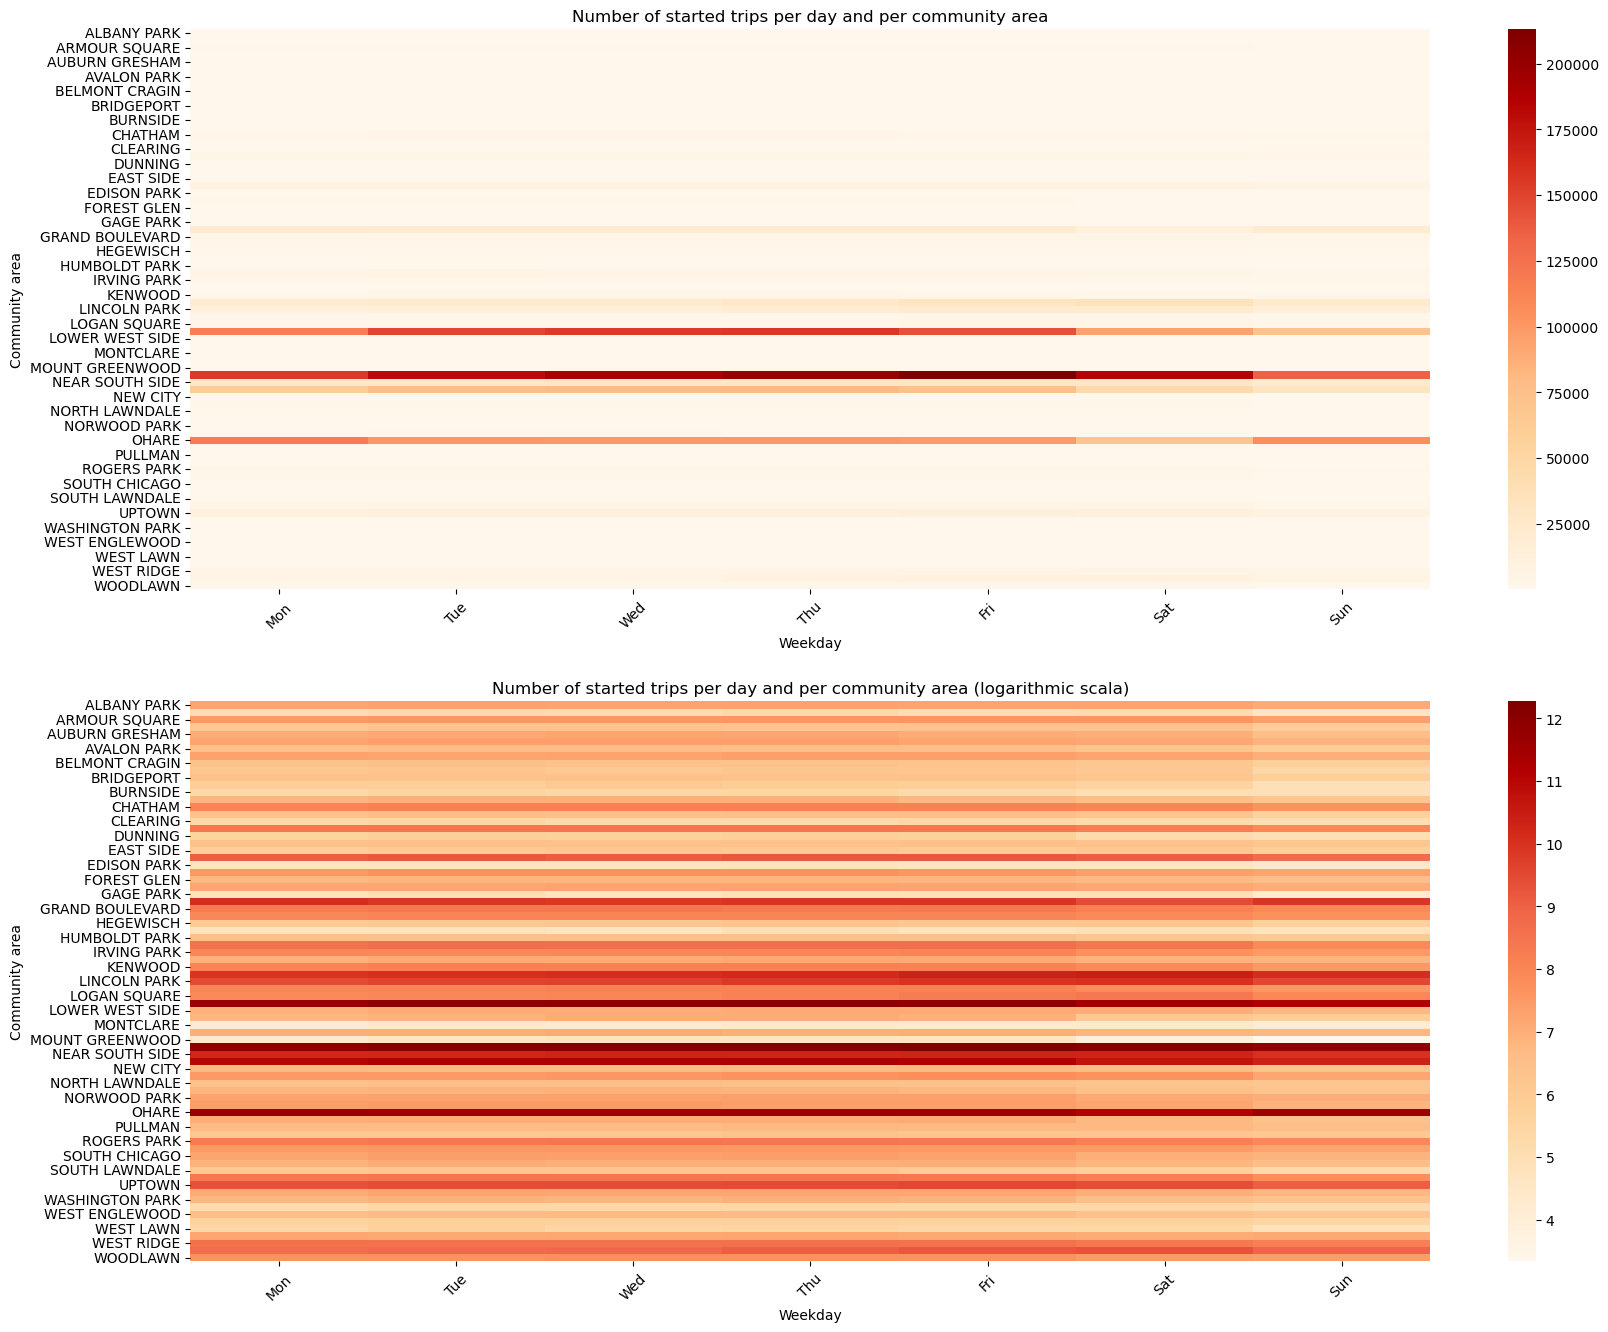

In [20]:
df_taxidata_startDay = df_taxidata
df_taxidata_startDay['number_of_trips_start_day'] = 0
df_taxidata_startDay = df_taxidata.groupby(['pickup_community', 'pickup_area_number', 'weekday'])['number_of_trips_start_day'].count().reset_index()

pivot_table_startDay = df_taxidata_startDay.pivot_table(index="pickup_community", columns="weekday", values="number_of_trips_start_day")
log_pivot_table_startDay = np.log1p(pivot_table_startDay)

plt.figure(figsize=(20,16))
custom_x_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

plt.subplot(2, 1, 1)
sns.heatmap(pivot_table_startDay, cmap='OrRd', xticklabels = custom_x_labels)
plt.title('Number of started trips per day and per community area')
plt.xlabel('Weekday')
plt.ylabel('Community area')
plt.xticks(rotation=45)

plt.subplot(2, 1, 2)
sns.heatmap(log_pivot_table_startDay, cmap='OrRd', xticklabels = custom_x_labels)
plt.title('Number of started trips per day and per community area (logarithmic scala)')
plt.xlabel('Weekday')
plt.ylabel('Community area')
plt.xticks(rotation=45)

plt.show()

Based on these heat maps, there are no major differences between the days of the week per community, except that there are generally slightly fewer trips on Sundays and Saturdays

### Average trip duration/ trip miles per weekday and hour

#### Trip duration:

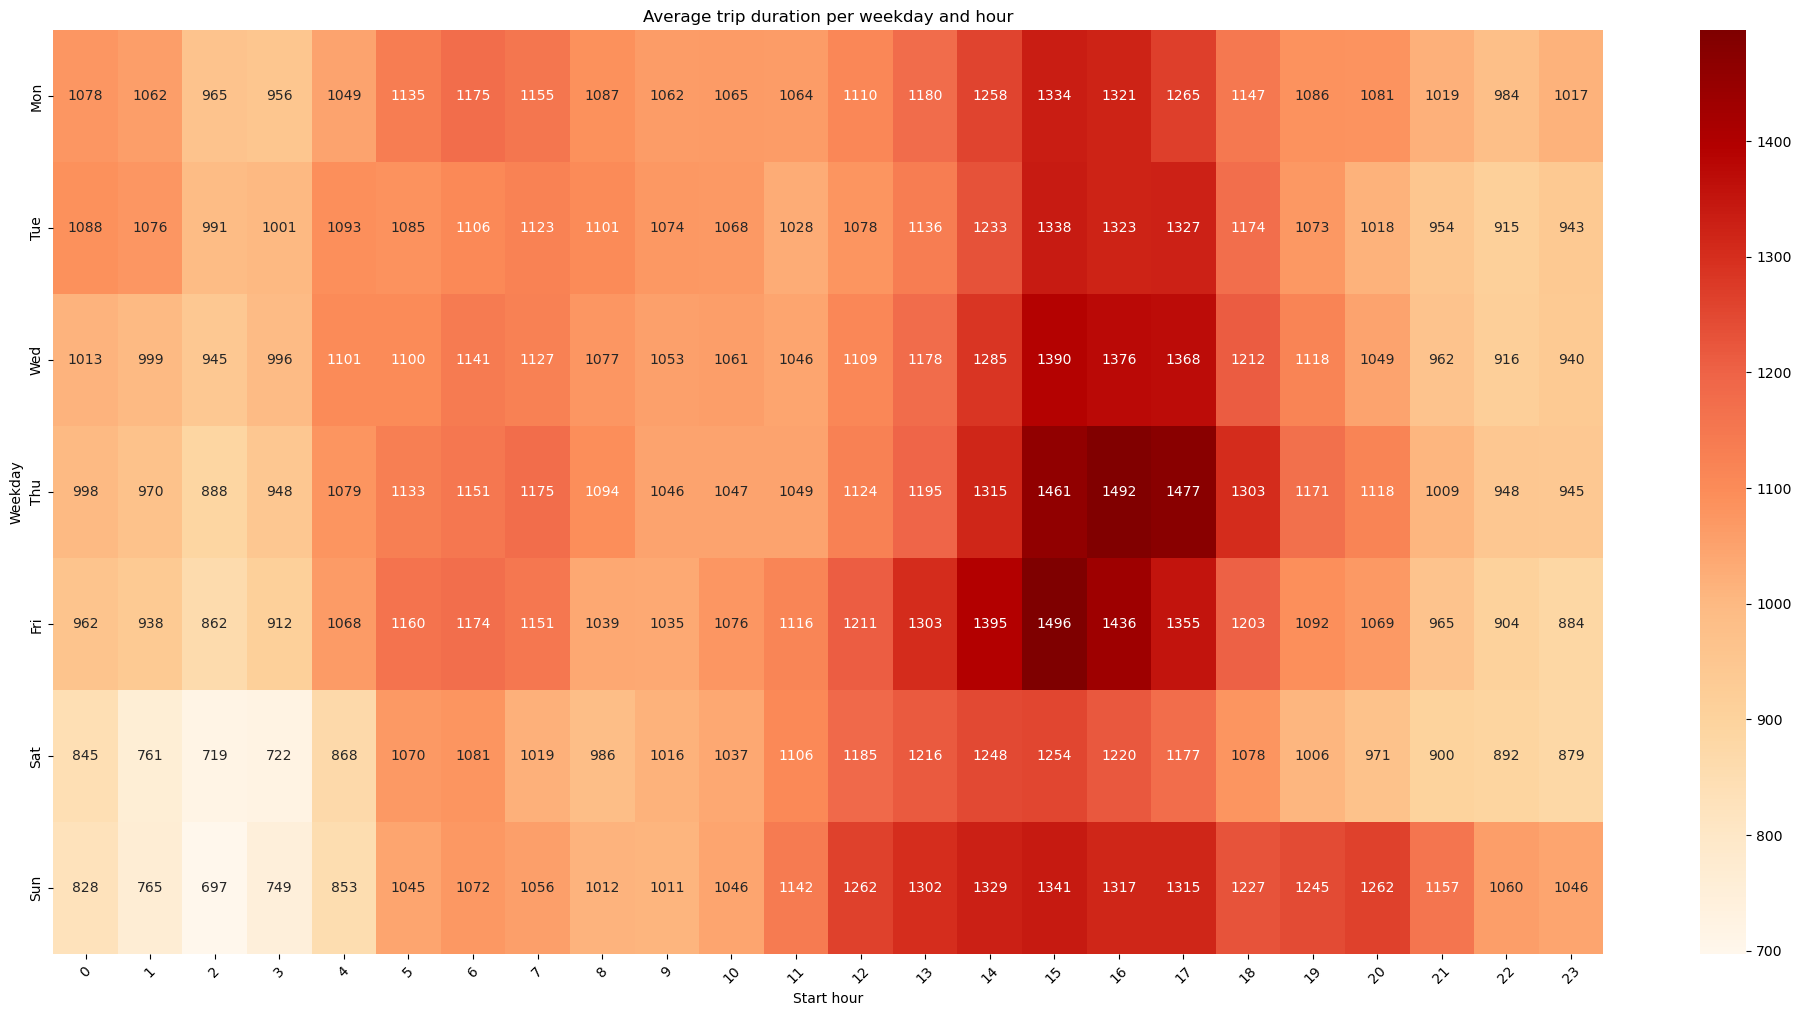

In [21]:
#1-hour window
df_taxidata_duration_day = df_taxidata
pivot_table_duration_day = df_taxidata_duration_day.pivot_table(index="weekday", columns="1_hour_window", values="trip_seconds", aggfunc='mean')

plt.figure(figsize=(25,12))
custom_y_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
sns.heatmap(pivot_table_duration_day, annot=True, fmt='.0f', cmap='OrRd', yticklabels=custom_y_labels)
plt.title('Average trip duration per weekday and hour')
plt.xlabel('Start hour')
plt.ylabel('Weekday')
plt.xticks(rotation=45)

plt.show()

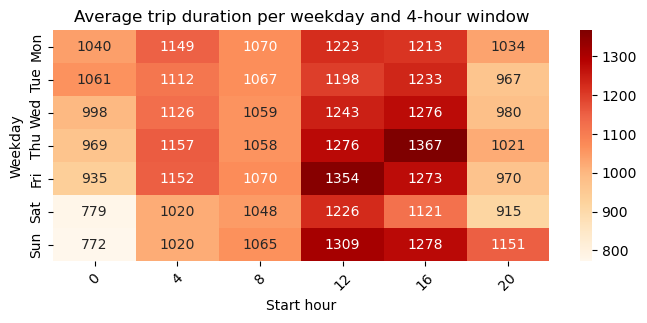

In [22]:
#4-hour window
df_taxidata_duration_day_four_hour_window = df_taxidata
pivot_table_duration_day_four_hour_window = df_taxidata_duration_day_four_hour_window.pivot_table(index="weekday", columns="4_hour_window", values="trip_seconds", aggfunc='mean')

plt.figure(figsize=(8,3))
custom_y_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
sns.heatmap(pivot_table_duration_day_four_hour_window, annot=True, fmt='.0f', cmap='OrRd', yticklabels=custom_y_labels)
plt.title('Average trip duration per weekday and 4-hour window')
plt.xlabel('Start hour')
plt.ylabel('Weekday')
plt.xticks(rotation=45)

plt.show()

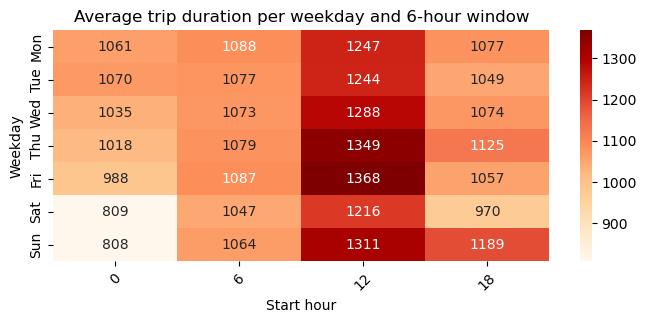

In [23]:
#6-hour window
df_taxidata_duration_day_six_hour_window = df_taxidata
pivot_table_duration_day_six_hour_window = df_taxidata_duration_day_six_hour_window.pivot_table(index="weekday", columns="6_hour_window", values="trip_seconds", aggfunc='mean')

plt.figure(figsize=(8,3))
custom_y_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
sns.heatmap(pivot_table_duration_day_six_hour_window, annot=True, fmt='.0f', cmap='OrRd', yticklabels=custom_y_labels)
plt.title('Average trip duration per weekday and 6-hour window')
plt.xlabel('Start hour')
plt.ylabel('Weekday')
plt.xticks(rotation=45)

plt.show()

Using the temporal resolution of a 4-hour and a 6-hour window, you can see more clearly that the duration of the trips also depends on the time of day. The trips seem to take longer, especially at midday and in the afternoon from around 12. to 8 p.m. and 12 p.m. to 6 p.m. respectively. 

It is now possible to further analyse whether there are simply moderately longer trips at these times, or whether the duration is increased due to a higher volume of traffic at these times, but the distances travelled are roughly the same.

#### Trip miles:

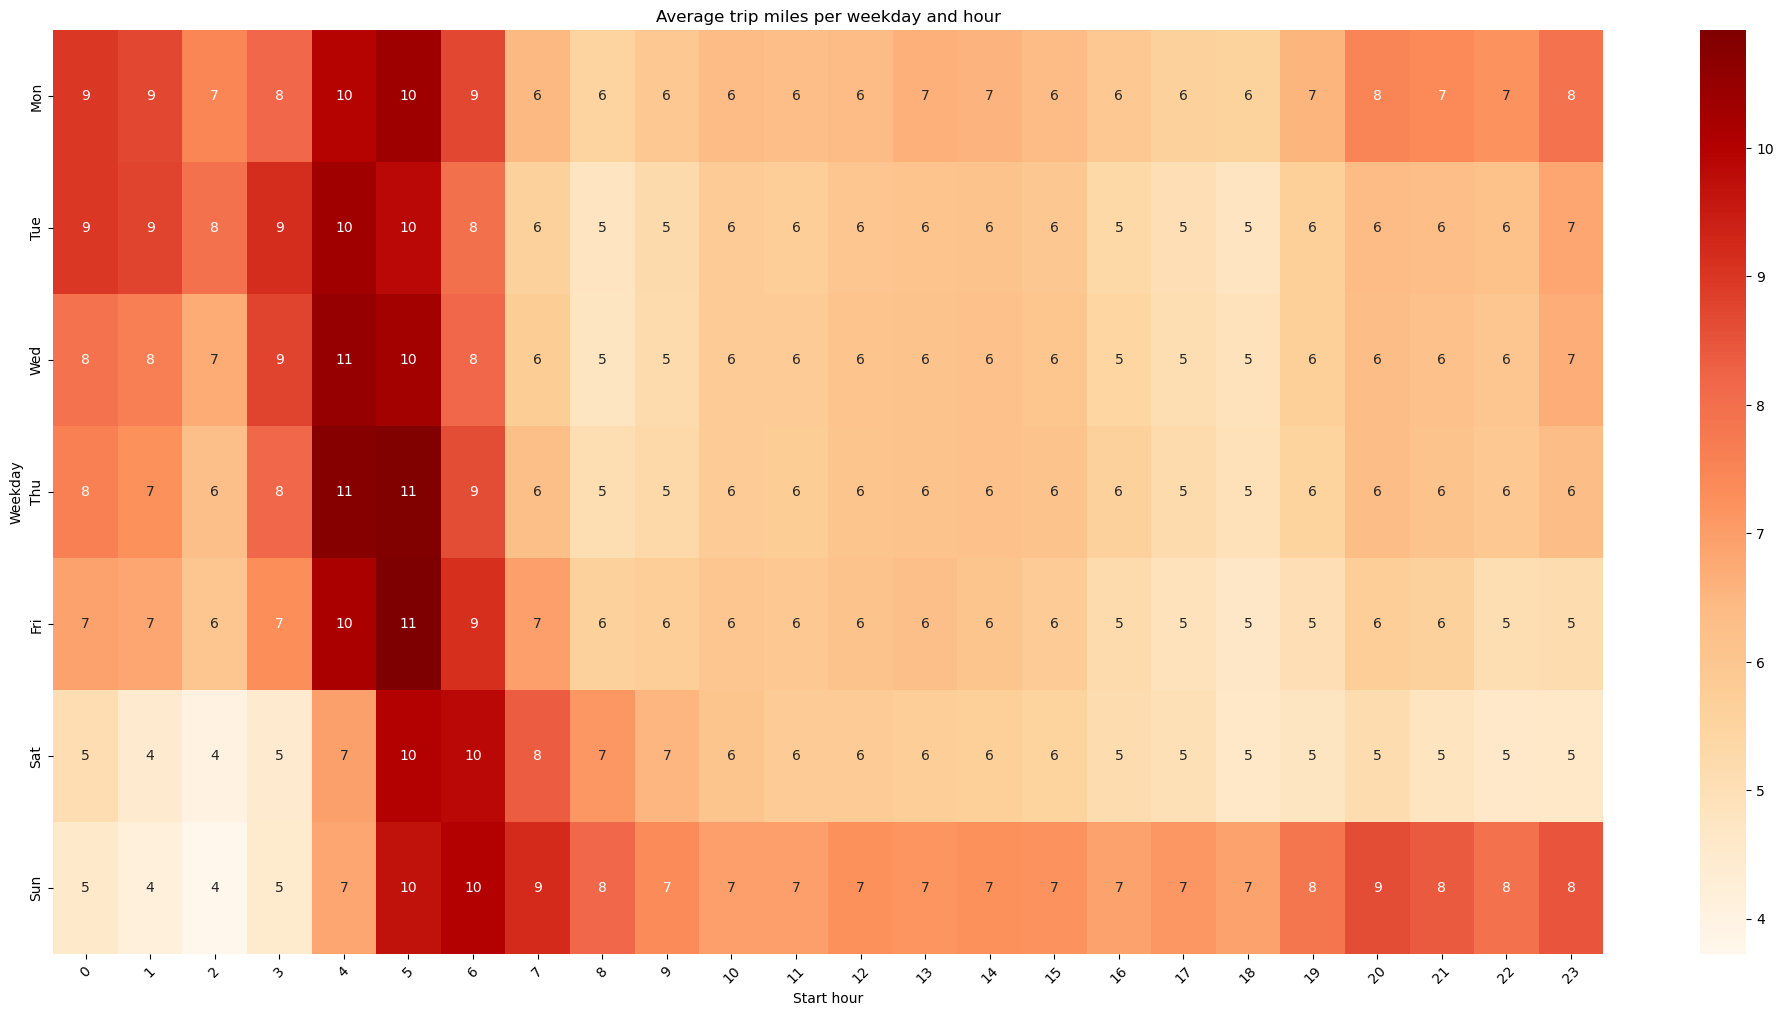

In [24]:
#1-hour window
df_taxidata_miles_day = df_taxidata
pivot_table_miles_day = df_taxidata_miles_day.pivot_table(index="weekday", columns="1_hour_window", values="trip_miles", aggfunc='mean')

plt.figure(figsize=(25,12))
custom_y_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
sns.heatmap(pivot_table_miles_day, annot=True, fmt='.0f', cmap='OrRd', yticklabels=custom_y_labels)
plt.title('Average trip miles per weekday and hour')
plt.xlabel('Start hour')
plt.ylabel('Weekday')
plt.xticks(rotation=45)

plt.show()

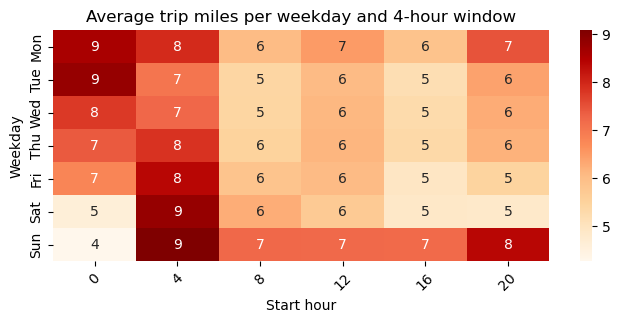

In [25]:
#4-hour window
df_taxidata_miles_day_four_hour_window = df_taxidata
pivot_table_miles_day_four_hour_window = df_taxidata_miles_day_four_hour_window.pivot_table(index="weekday", columns="4_hour_window", values="trip_miles", aggfunc='mean')

plt.figure(figsize=(8,3))
custom_y_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
sns.heatmap(pivot_table_miles_day_four_hour_window, annot=True, fmt='.0f', cmap='OrRd', yticklabels=custom_y_labels)
plt.title('Average trip miles per weekday and 4-hour window')
plt.xlabel('Start hour')
plt.ylabel('Weekday')
plt.xticks(rotation=45)

plt.show()

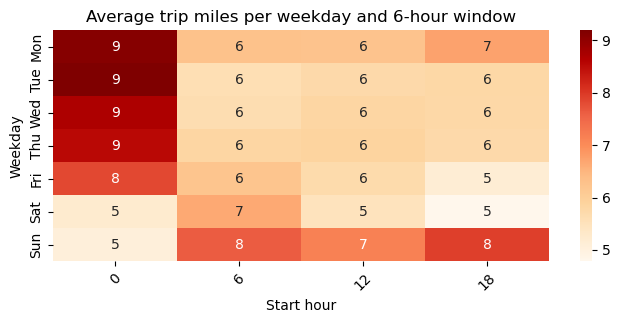

In [26]:
#6-hour window
df_taxidata_miles_day_six_hour_window = df_taxidata
pivot_table_miles_day_six_hour_window = df_taxidata_miles_day_six_hour_window.pivot_table(index="weekday", columns="6_hour_window", values="trip_miles", aggfunc='mean')

plt.figure(figsize=(8,3))
custom_y_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
sns.heatmap(pivot_table_miles_day_six_hour_window, annot=True, fmt='.0f', cmap='OrRd', yticklabels=custom_y_labels)
plt.title('Average trip miles per weekday and 6-hour window')
plt.xlabel('Start hour')
plt.ylabel('Weekday')
plt.xticks(rotation=45)

plt.show()

If we now look at the average miles driven per trip per hour and weekday, we see that this does not correlate with the trip duration results. 

In this case, the number of miles is higher at night or in the morning and very low at midday or in the afternoon.

It can be concluded from this that the trips take longer at midday and in the afternoon due to the volume of traffic and not because longer trips are made there. The longer trips tend to be made in the morning, perhaps when commuters are travelling into the city to work.

### Average trip duration/ trip miles per community area

#### Trip duration:

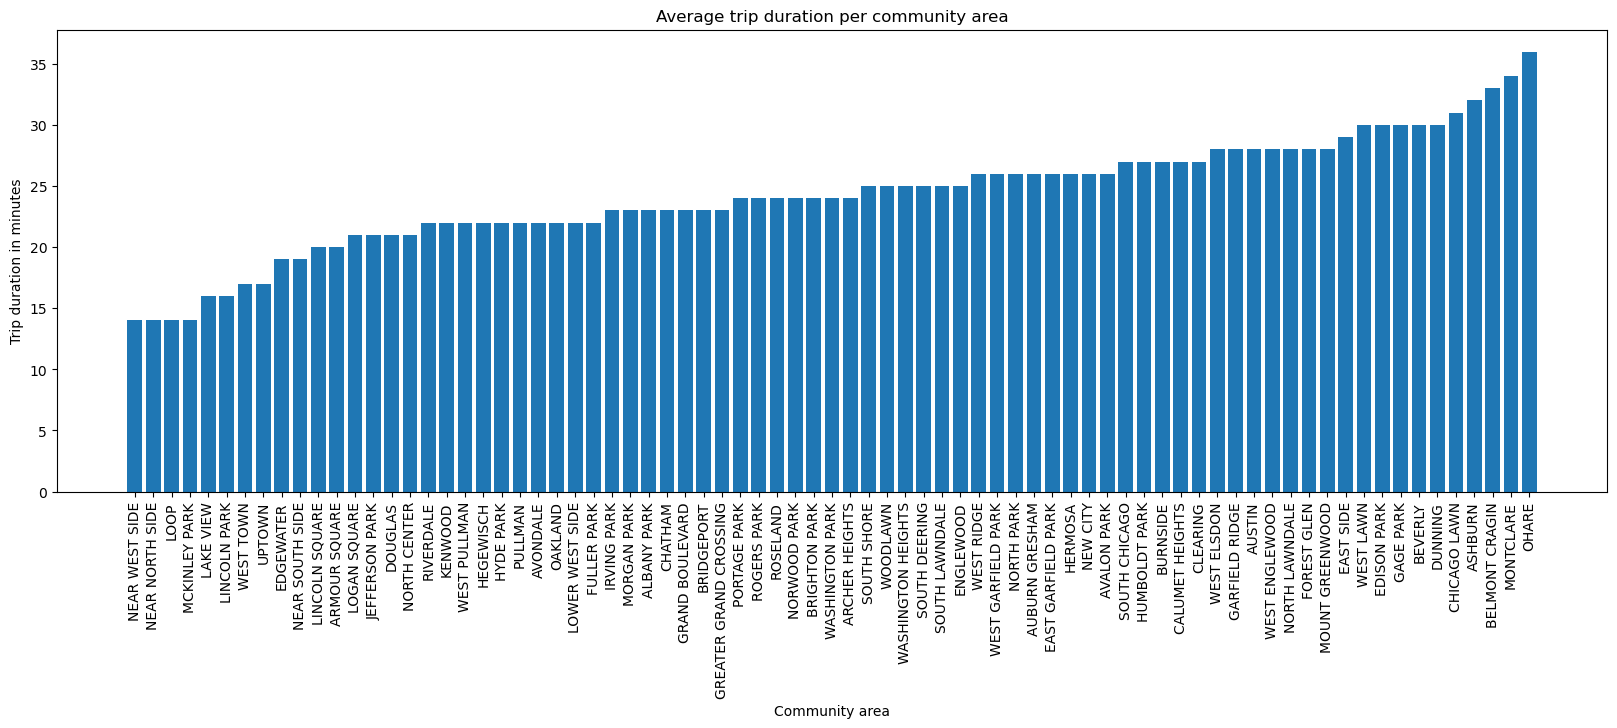

In [27]:
df_taxidata_trip_duration = df_taxidata
df_taxidata_trip_duration = df_taxidata.groupby(['pickup_community', 'pickup_area_number'])['trip_seconds'].mean().round().reset_index()
df_taxidata_trip_duration = df_taxidata_trip_duration.merge(df_censusTrack, how='left', on='pickup_area_number')
df_taxidata_trip_duration['trip_minutes'] = (df_taxidata_trip_duration['trip_seconds'] / 60).round()

#sort x-axes based on average trip duration
df_taxidata_trip_duration = df_taxidata_trip_duration.sort_values(['trip_minutes']).reset_index()

plt.figure(figsize=(20,6))
plt.bar(df_taxidata_trip_duration['pickup_community'], df_taxidata_trip_duration['trip_minutes'])
plt.title('Average trip duration per community area')
plt.xlabel('Community area')
plt.ylabel('Trip duration in minutes')
plt.xticks(rotation=90)
plt.show()

<Figure size 2000x600 with 0 Axes>

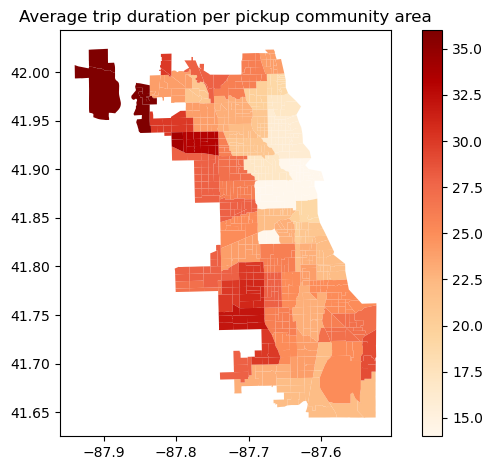

In [28]:
df_taxidata_trip_duration_geo = gp.GeoDataFrame(df_taxidata_trip_duration, geometry=df_taxidata_trip_duration['geometry'], crs='EPSG:4326')

plt.figure(figsize=(20,6))
df_taxidata_trip_duration_geo.plot(column="trip_minutes", legend=True, cmap = 'OrRd')
plt.title('Average trip duration per pickup community area')

plt.tight_layout()
plt.show()

This map shows that the duration of the trip depends heavily on the location and therefore on the community area. You can see that the duration is significantly shorter in the city centre in particular, which is most likely due to the fact that many short trips are made within the city. If you look at the areas further out, you can see that the trips that start there take significantly longer. It can be assumed that many trips from there go to the centre and therefore the average duration increases the further away from the centre you are.

#### Trip miles:

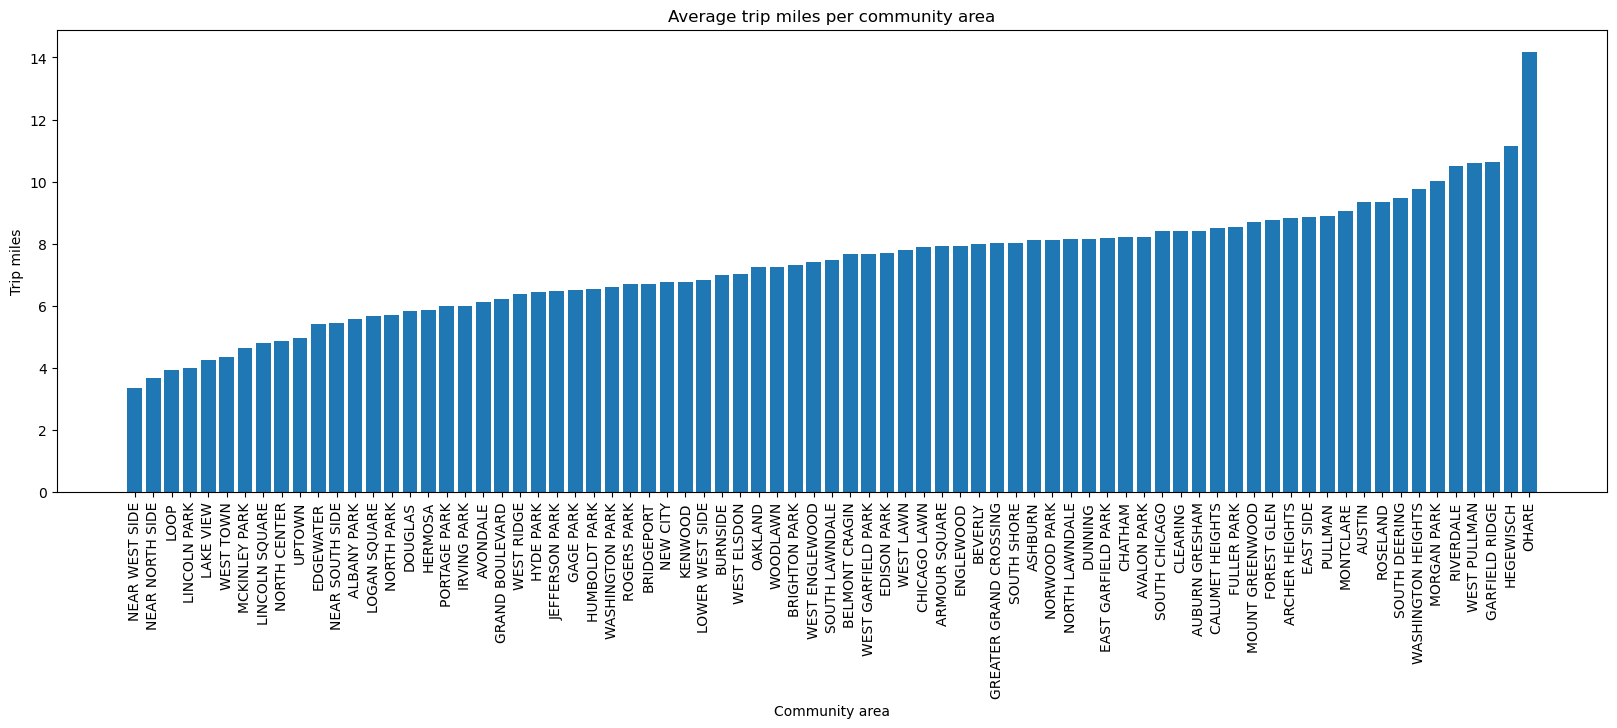

In [29]:
df_taxidata_trip_miles = df_taxidata.groupby(['pickup_community', 'pickup_area_number'])['trip_miles'].mean().reset_index()
df_taxidata_trip_miles = df_taxidata_trip_miles.merge(df_censusTrack, how='left', on='pickup_area_number')

#sort x-axes based on average trip miles
df_taxidata_trip_miles = df_taxidata_trip_miles.sort_values(['trip_miles']).reset_index()

plt.figure(figsize=(20,6))
plt.bar(df_taxidata_trip_miles['pickup_community'], df_taxidata_trip_miles['trip_miles'])
plt.title('Average trip miles per community area')
plt.xlabel('Community area')
plt.ylabel('Trip miles')
plt.xticks(rotation=90)
plt.show()

<Figure size 2000x600 with 0 Axes>

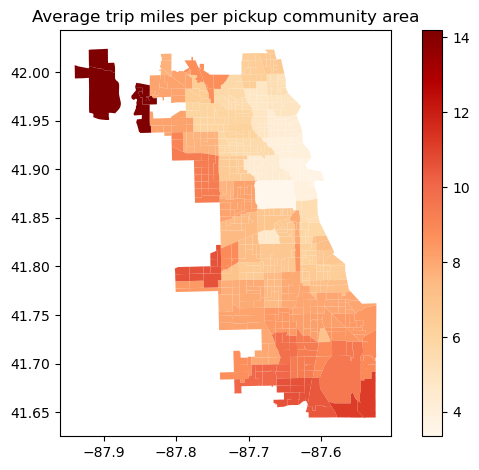

In [30]:
df_taxidata_trip_miles_geo = gp.GeoDataFrame(df_taxidata_trip_miles, geometry=df_taxidata_trip_miles['geometry'], crs='EPSG:4326')

plt.figure(figsize=(20,6))
df_taxidata_trip_miles_geo.plot(column="trip_miles", legend=True, cmap = 'OrRd')
plt.title('Average trip miles per pickup community area')

plt.tight_layout()
plt.show()

This map also shows similar behaviour to the previous evaluation of trip duration. The further outside the community area, the higher the average number of miles travelled.

### Average fare prices per weekday and hour

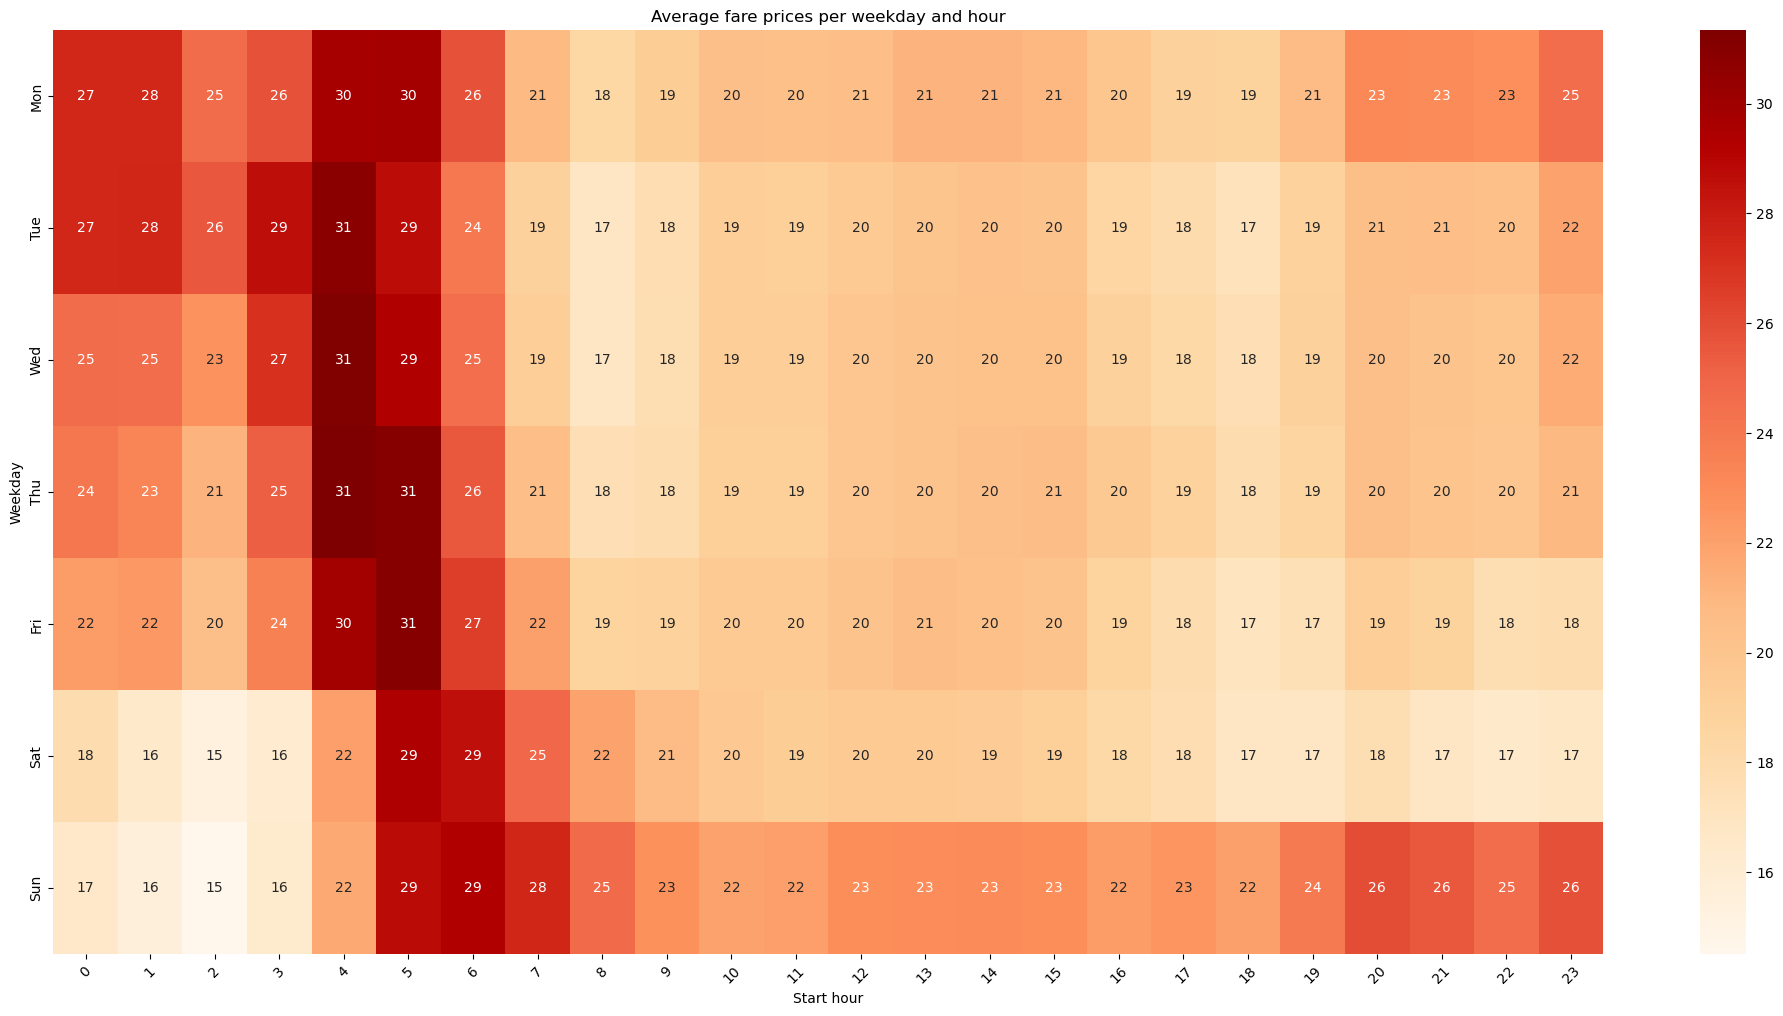

In [35]:
#1-hour window
df_taxidata_prices_day = df_taxidata
pivot_table_prices_day = df_taxidata_prices_day.pivot_table(index="weekday", columns="1_hour_window", values="fare", aggfunc='mean')

plt.figure(figsize=(25,12))
custom_y_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
sns.heatmap(pivot_table_prices_day, annot=True, fmt='.0f', cmap='OrRd', yticklabels=custom_y_labels)
plt.title('Average fare prices per weekday and hour')
plt.xlabel('Start hour')
plt.ylabel('Weekday')
plt.xticks(rotation=45)

plt.show()

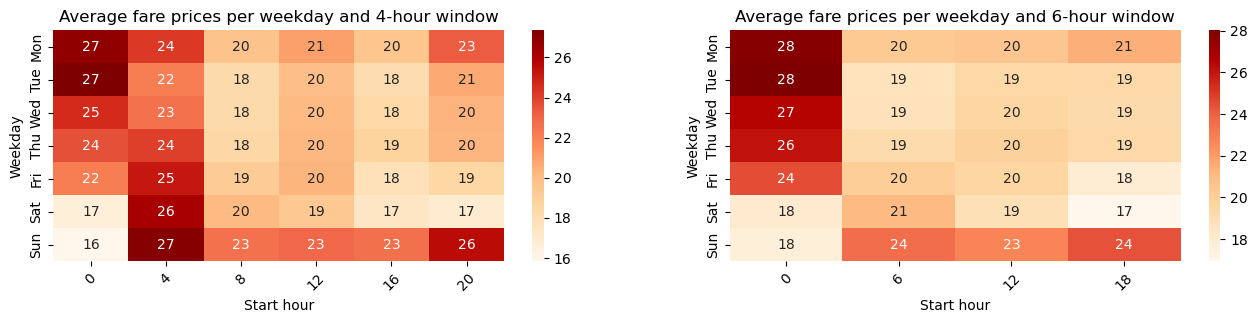

In [38]:
#4-hour window
df_taxidata_prices_day_four_hour_window = df_taxidata
pivot_table_prices_day_four_hour_window = df_taxidata_prices_day_four_hour_window.pivot_table(index="weekday", columns="4_hour_window", values="fare", aggfunc='mean')

plt.figure(figsize=(16,3))

plt.subplot(1, 2, 1)
custom_y_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
sns.heatmap(pivot_table_prices_day_four_hour_window, annot=True, fmt='.0f', cmap='OrRd', yticklabels=custom_y_labels)
plt.title('Average fare prices per weekday and 4-hour window')
plt.xlabel('Start hour')
plt.ylabel('Weekday')
plt.xticks(rotation=45)

#6-hour window
df_taxidata_prices_day_six_hour_window = df_taxidata
pivot_table_prices_day_six_hour_window = df_taxidata_prices_day_six_hour_window.pivot_table(index="weekday", columns="6_hour_window", values="fare", aggfunc='mean')

plt.subplot(1, 2, 2)
custom_y_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
sns.heatmap(pivot_table_prices_day_six_hour_window, annot=True, fmt='.0f', cmap='OrRd', yticklabels=custom_y_labels)
plt.title('Average fare prices per weekday and 6-hour window')
plt.xlabel('Start hour')
plt.ylabel('Weekday')
plt.xticks(rotation=45)

plt.show()

It can be seen that prices are significantly higher at night and on Sundays than during the rest of the day and week. However, this is most likely due to the fact that a higher number of miles are driven at these times (see section Average trip miles), as the diagrams of both analyses look similar. In addition, taxi journeys in Chicago are charged by the miles (https://yellowcabchicago.com/rates/). Thats why we will next look at the prices per miles for better analyses.

#### Average fare prices per miles

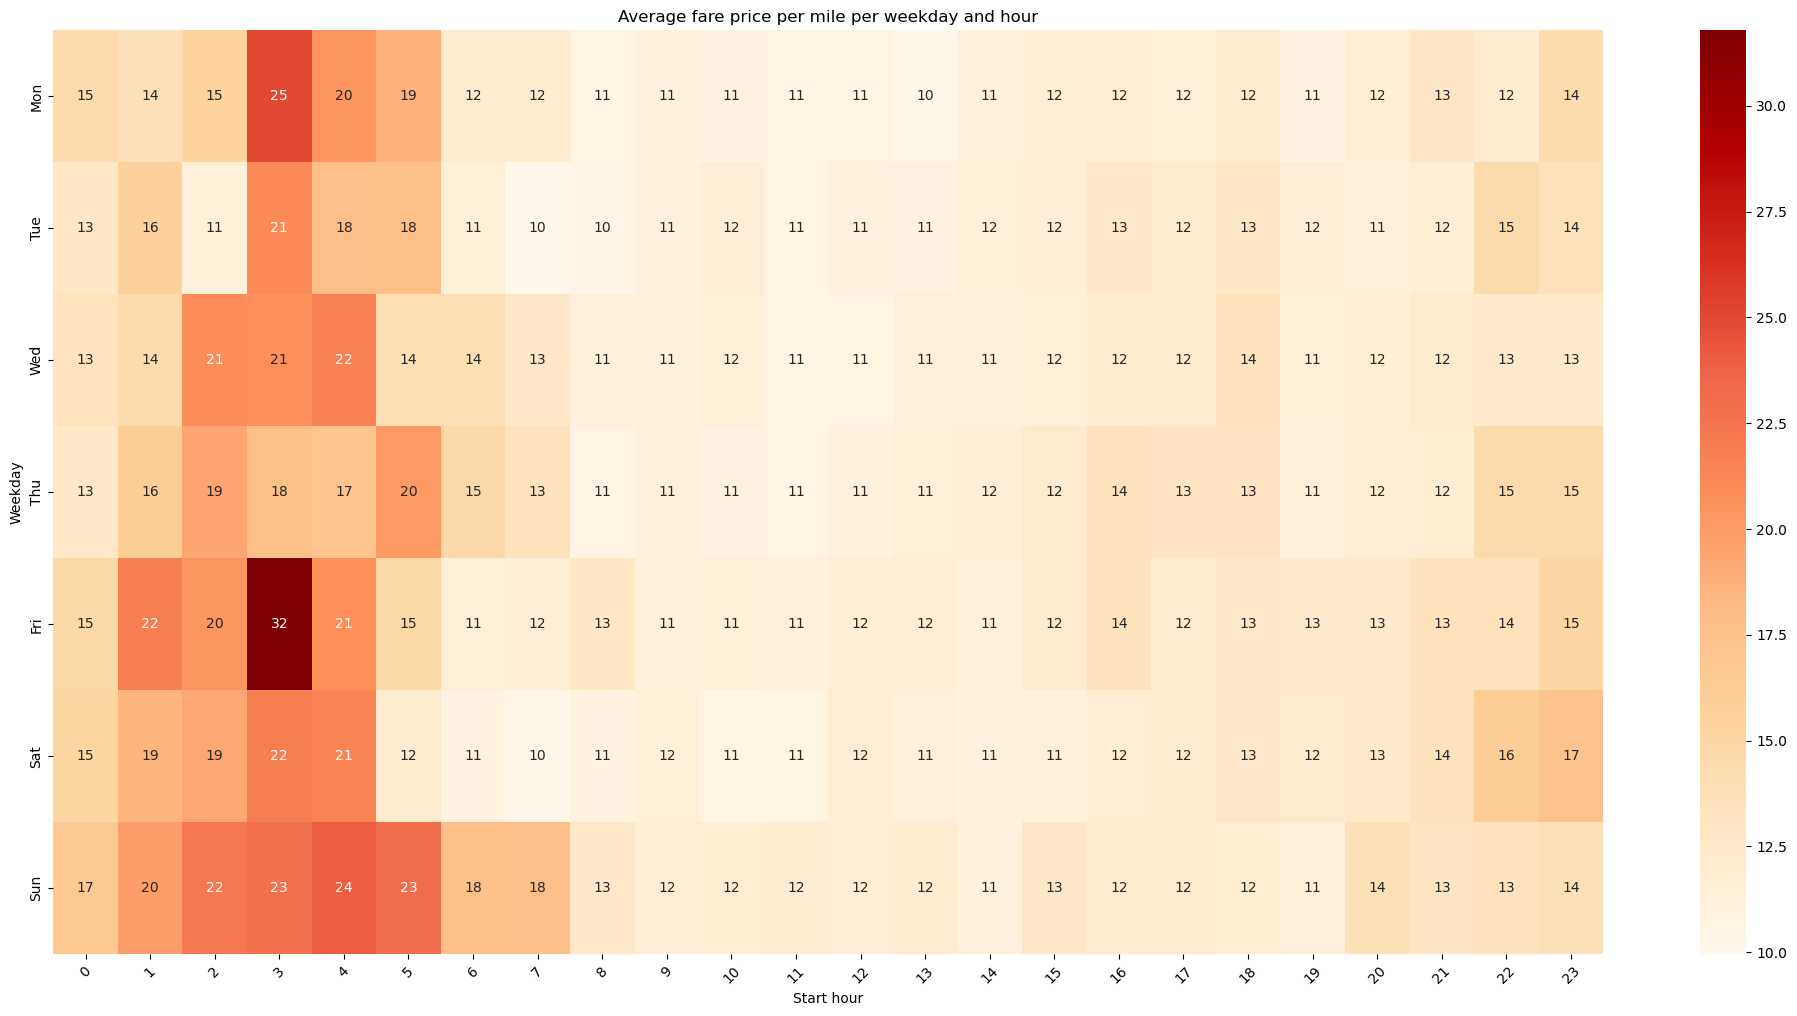

In [43]:
#1-hour window
df_taxidata_prices_per_mile_day = df_taxidata
df_taxidata_prices_per_mile_day['fare_per_mile'] = df_taxidata_prices_per_mile_day['fare'] / df_taxidata_prices_per_mile_day['trip_miles']
pivot_table_prices_per_mile_day = df_taxidata_prices_per_mile_day.pivot_table(index="weekday", columns="1_hour_window", values="fare_per_mile", aggfunc='mean')

plt.figure(figsize=(25,12))
custom_y_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
sns.heatmap(pivot_table_prices_per_mile_day, annot=True, fmt='.0f', cmap='OrRd', yticklabels=custom_y_labels)
plt.title('Average fare price per mile per weekday and hour')
plt.xlabel('Start hour')
plt.ylabel('Weekday')
plt.xticks(rotation=45)

plt.show()

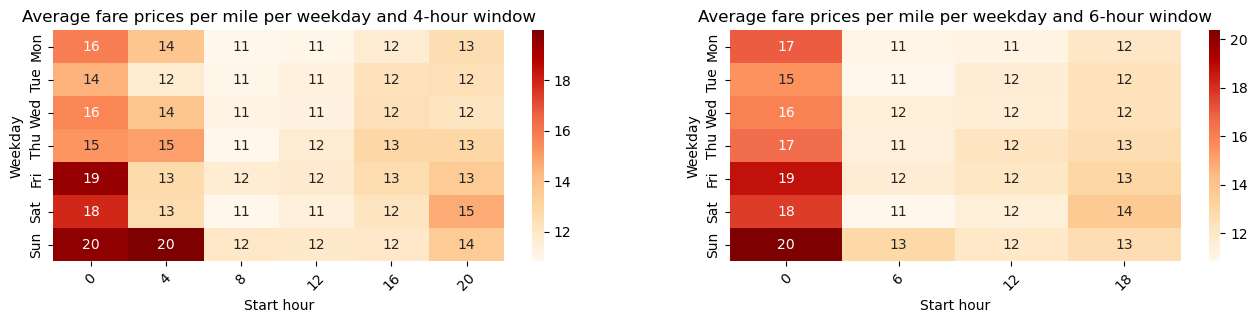

In [44]:
#4-hour window
df_taxidata_prices_per_mile_day_four_hour_window = df_taxidata
df_taxidata_prices_per_mile_day_four_hour_window['fare_per_mile'] = df_taxidata_prices_per_mile_day_four_hour_window['fare'] / df_taxidata_prices_per_mile_day_four_hour_window['trip_miles']
pivot_table_prices_per_mile_day_four_hour_window = df_taxidata_prices_per_mile_day_four_hour_window.pivot_table(index="weekday", columns="4_hour_window", values="fare_per_mile", aggfunc='mean')

plt.figure(figsize=(16,3))

plt.subplot(1, 2, 1)
custom_y_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
sns.heatmap(pivot_table_prices_per_mile_day_four_hour_window, annot=True, fmt='.0f', cmap='OrRd', yticklabels=custom_y_labels)
plt.title('Average fare prices per mile per weekday and 4-hour window')
plt.xlabel('Start hour')
plt.ylabel('Weekday')
plt.xticks(rotation=45)

#6-hour window
df_taxidata_prices_per_mile_day_six_hour_window = df_taxidata
df_taxidata_prices_per_mile_day_six_hour_window['fare_per_mile'] = df_taxidata_prices_per_mile_day_six_hour_window['fare'] / df_taxidata_prices_per_mile_day_six_hour_window['trip_miles']
pivot_table_prices_per_mile_day_six_hour_window = df_taxidata_prices_per_mile_day_six_hour_window.pivot_table(index="weekday", columns="6_hour_window", values="fare_per_mile", aggfunc='mean')

plt.subplot(1, 2, 2)
custom_y_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
sns.heatmap(pivot_table_prices_per_mile_day_six_hour_window, annot=True, fmt='.0f', cmap='OrRd', yticklabels=custom_y_labels)
plt.title('Average fare prices per mile per weekday and 6-hour window')
plt.xlabel('Start hour')
plt.ylabel('Weekday')
plt.xticks(rotation=45)

plt.show()

By visualising the fare prices per mile, you can see more clearly that there are barely any differences during the day and between the days of the week. The only thing that can be said clearly is that trips at night are generally more expensive than during the day.

It would now be interesting to see whether prices differ not only at different times, but also depending on the community area, which we will analyse below. For the purpose of clarity, we will only consider the fare prices per mile and not the total fare prices.

### Average fare prices per mile per community area

<Figure size 2000x600 with 0 Axes>

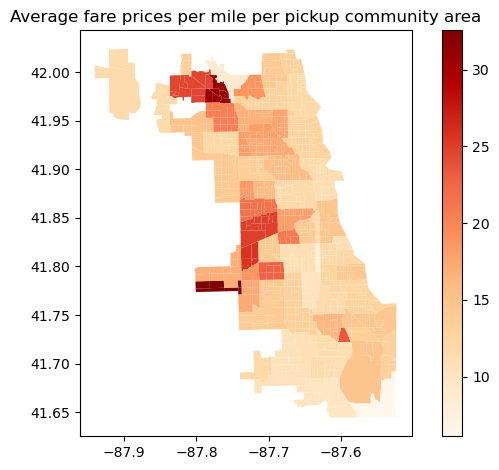

In [45]:
df_taxidata_trip_prices_per_mile = df_taxidata
df_taxidata_trip_prices_per_mile['fare_per_mile'] = df_taxidata_trip_prices_per_mile['fare'] / df_taxidata_trip_prices_per_mile['trip_miles']
df_taxidata_trip_prices_per_mile = df_taxidata_trip_prices_per_mile.groupby(['pickup_community', 'pickup_area_number'])['fare_per_mile'].mean().reset_index()
df_taxidata_trip_prices_per_mile = df_taxidata_trip_prices_per_mile.merge(df_censusTrack, how='left', on='pickup_area_number')

df_taxidata_trip_prices_per_mile_geo = gp.GeoDataFrame(df_taxidata_trip_prices_per_mile, geometry=df_taxidata_trip_prices_per_mile['geometry'], crs='EPSG:4326')

plt.figure(figsize=(20,6))
df_taxidata_trip_prices_per_mile_geo.plot(column="fare_per_mile", legend=True, cmap = 'OrRd')
plt.title('Average fare prices per mile per pickup community area')

plt.tight_layout()
plt.show()

The map shows that certain community areas have higher prices than the rest, but there is no obvious pattern. 

Another point to be analysed would be the tips, whether these differ from each other in terms of time and location.

### Average tips per weekday and hour

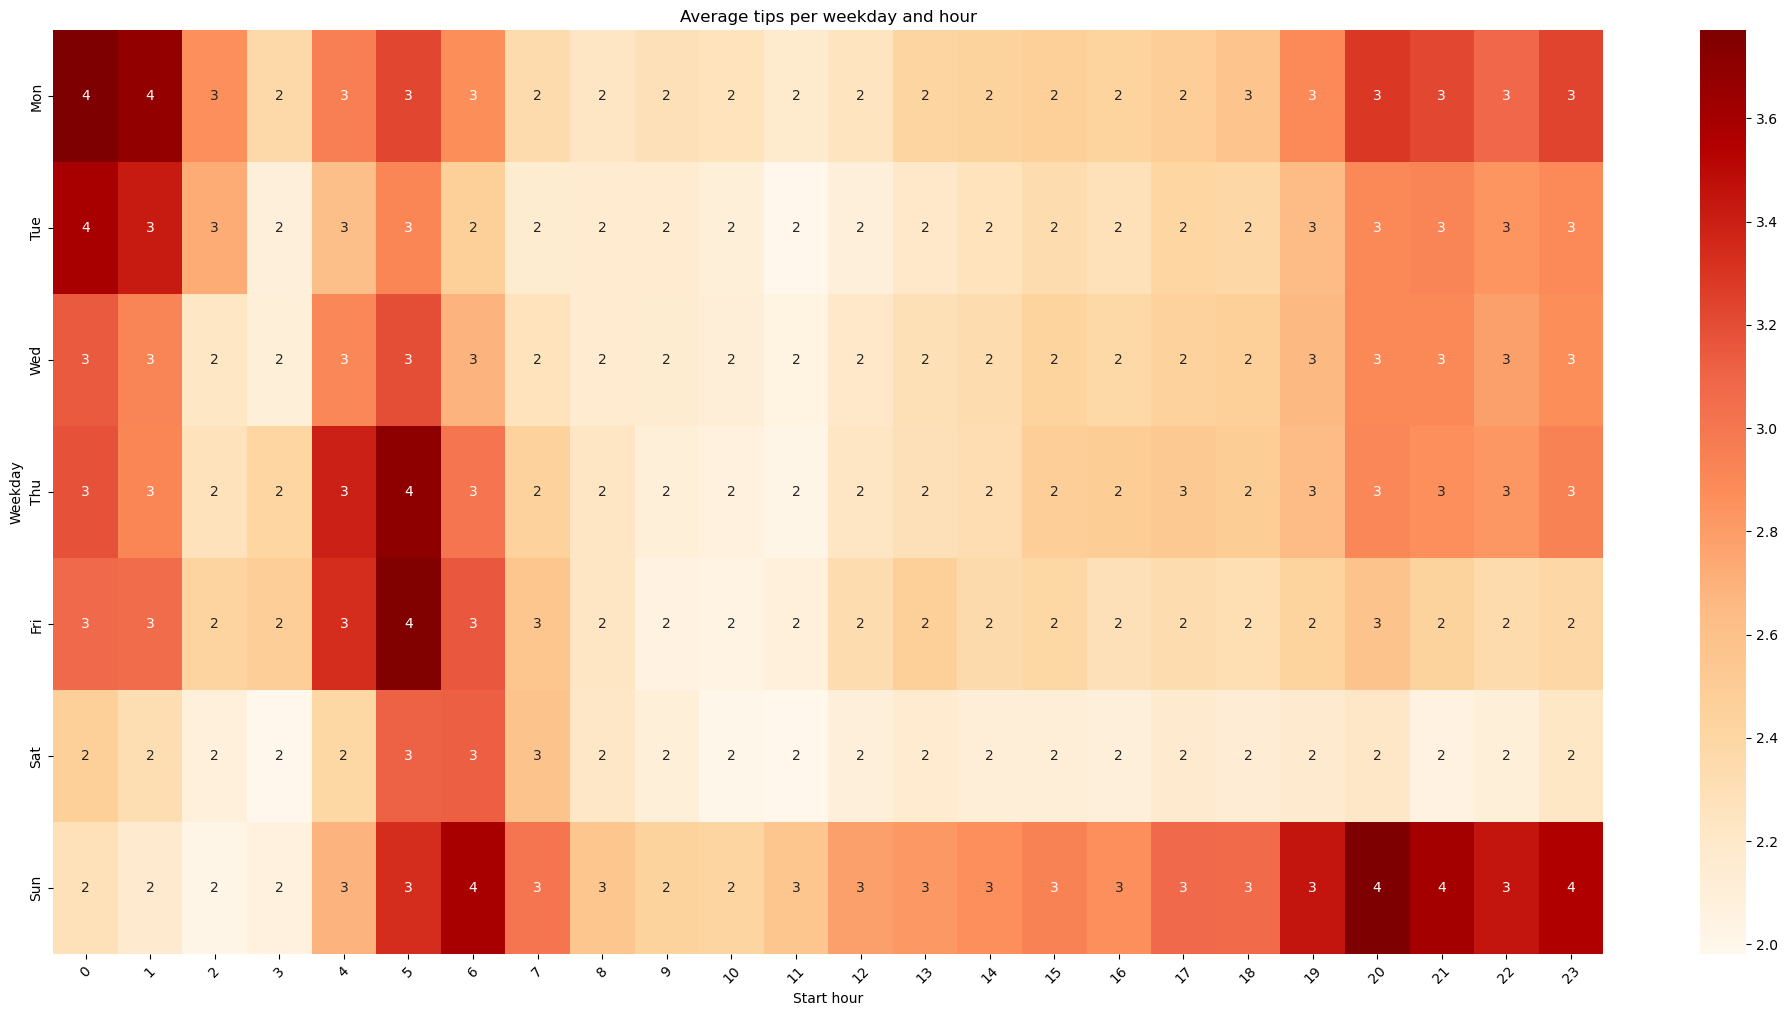

In [46]:
#1-hour window
df_taxidata_tips_day = df_taxidata
pivot_table_tips_day = df_taxidata_tips_day.pivot_table(index="weekday", columns="1_hour_window", values="tips", aggfunc='mean')

plt.figure(figsize=(25,12))
custom_y_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
sns.heatmap(pivot_table_tips_day, annot=True, fmt='.0f', cmap='OrRd', yticklabels=custom_y_labels)
plt.title('Average tips per weekday and hour')
plt.xlabel('Start hour')
plt.ylabel('Weekday')
plt.xticks(rotation=45)

plt.show()

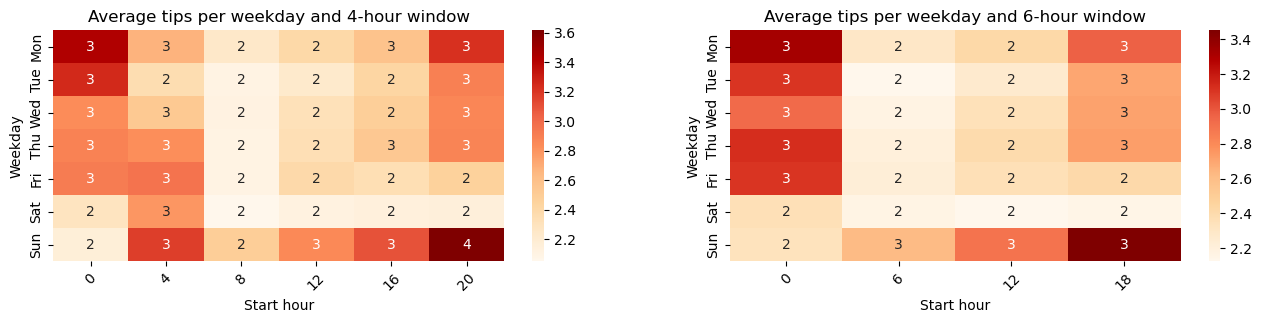

In [47]:
#4-hour window
df_taxidata_tips_day_four_hour_window = df_taxidata
pivot_table_tips_day_four_hour_window = df_taxidata_tips_day_four_hour_window.pivot_table(index="weekday", columns="4_hour_window", values="tips", aggfunc='mean')

plt.figure(figsize=(16,3))

plt.subplot(1, 2, 1)
custom_y_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
sns.heatmap(pivot_table_tips_day_four_hour_window, annot=True, fmt='.0f', cmap='OrRd', yticklabels=custom_y_labels)
plt.title('Average tips per weekday and 4-hour window')
plt.xlabel('Start hour')
plt.ylabel('Weekday')
plt.xticks(rotation=45)

#6-hour window
df_taxidata_tips_day_six_hour_window = df_taxidata
pivot_table_tips_day_six_hour_window = df_taxidata_tips_day_six_hour_window.pivot_table(index="weekday", columns="6_hour_window", values="tips", aggfunc='mean')

plt.subplot(1, 2, 2)
custom_y_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
sns.heatmap(pivot_table_tips_day_six_hour_window, annot=True, fmt='.0f', cmap='OrRd', yticklabels=custom_y_labels)
plt.title('Average tips per weekday and 6-hour window')
plt.xlabel('Start hour')
plt.ylabel('Weekday')
plt.xticks(rotation=45)

plt.show()

You can see that there are no moderately large differences in value, but generally the tips are slightly higher at night during the week and during the day on Sundays. In the following, we will now look at whether the tips differ between the various community areas.

### Average tips per community area

<Figure size 2000x600 with 0 Axes>

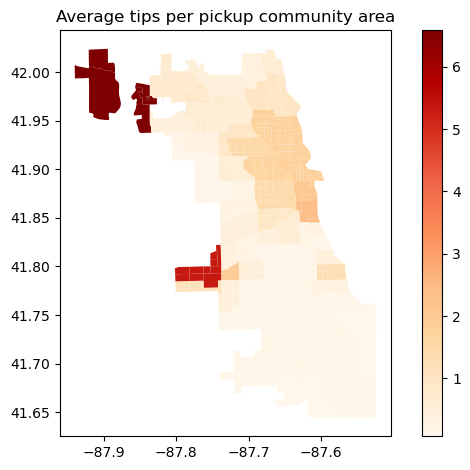

In [48]:
df_taxidata_trip_tips = df_taxidata.groupby(['pickup_community', 'pickup_area_number'])['tips'].mean().reset_index()
df_taxidata_trip_tips = df_taxidata_trip_tips.merge(df_censusTrack, how='left', on='pickup_area_number')

df_taxidata_trip_tips_geo = gp.GeoDataFrame(df_taxidata_trip_tips, geometry=df_taxidata_trip_tips['geometry'], crs='EPSG:4326')

plt.figure(figsize=(20,6))
df_taxidata_trip_tips_geo.plot(column="tips", legend=True, cmap = 'OrRd')
plt.title('Average tips per pickup community area')

plt.tight_layout()
plt.show()

The map shows 3 community areas where the tips are significantly higher compared to the other community areas.>

In [94]:
df_community.rename(columns = {'dropoff_area_number':'pickup_area_number'}, inplace = True)
df_community


community pickup_area_number  \
0           DOUGLAS                 35   
1           OAKLAND                 36   
2       FULLER PARK                 37   
3   GRAND BOULEVARD                 38   
4           KENWOOD                 39   
..              ...                ...   
72  MOUNT GREENWOOD                 74   
73      MORGAN PARK                 75   
74            OHARE                 76   
75        EDGEWATER                 77   
76      EDISON PARK                  9   

                                             geometry  
0   MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ...  
1   MULTIPOLYGON (((-87.59215 41.81693, -87.59231 ...  
2   MULTIPOLYGON (((-87.62880 41.80189, -87.62879 ...  
3   MULTIPOLYGON (((-87.60671 41.81681, -87.60670 ...  
4   MULTIPOLYGON (((-87.59215 41.81693, -87.59215 ...  
..                                                ...  
72  MULTIPOLYGON (((-87.69646 41.70714, -87.69644 ...  
73  MULTIPOLYGON (((-87.64215 41.68508, -87.64249 ...  
74  MULTIPOLYGON (((-87.83658 41.98640, -87.83658 ...  
75  MULTIPOLYGON (((-87.65456 41.99817, -87.65456 ...  
76  MULTIPOLYGON (((-87.80676 42.00084, -87.80676 ...  

[77 rows x 3 columns]

In [32]:
df_community = gp.read_file('data/prepped/community_df.geojson')
df_community.rename(columns = {'area_number':'pickup_area_number'}, inplace = True)

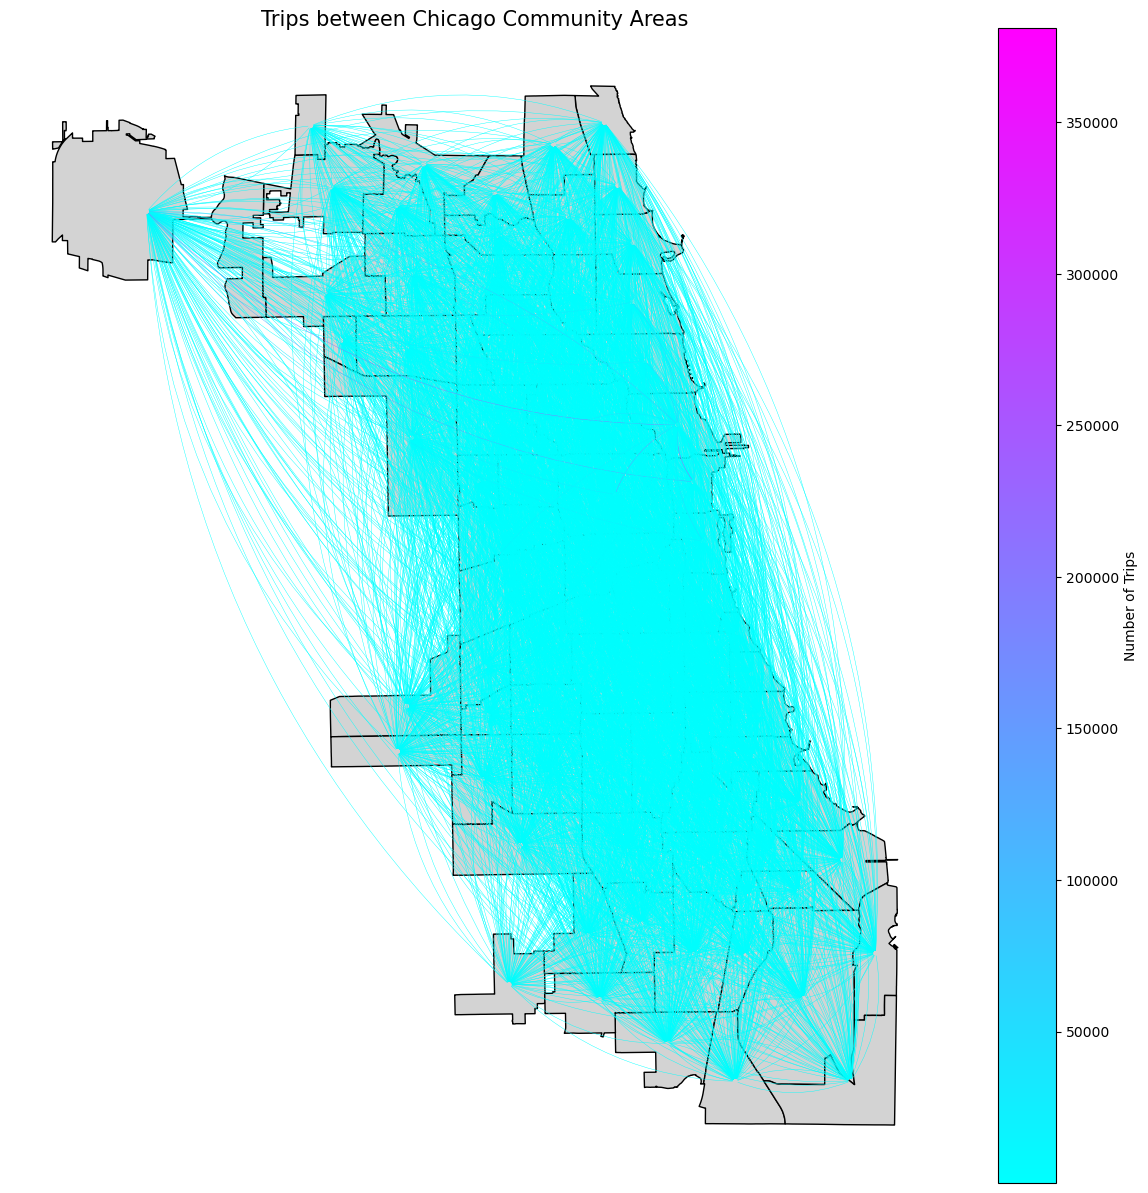

In [95]:
# Get number of trips between each pair of communities
df_taxidata_count_routes = df_taxidata
df_taxidata_count_routes = df_taxidata_count_routes.groupby(['pickup_area_number', 'dropoff_area_number']).size().reset_index(name='number_of_trips')

# Merge geometry of pickup community
df_taxidata_count_routes = df_taxidata_count_routes.merge(df_community, how='left', on='pickup_area_number')
df_taxidata_count_routes.rename(columns = {'geometry':'geometry_pickup'}, inplace = True)

# Merge geometry of dropoff community
df_community.rename(columns = {'pickup_area_number':'dropoff_area_number'}, inplace = True)
df_taxidata_count_routes = df_taxidata_count_routes.merge(df_community, how='left', on='dropoff_area_number')
df_taxidata_count_routes.rename(columns = {'geometry':'geometry_dropoff'}, inplace = True)

df_taxidata_count_routes = df_taxidata_count_routes.drop('community_x', axis=1)
df_taxidata_count_routes = df_taxidata_count_routes.drop('community_y', axis=1)

# Calculate centroids for each community area for arc drawing
df_community_areas = df_community
df_community_areas = df_community_areas.to_crs(epsg=26916)
df_community_areas['centroid'] = df_community_areas.geometry.centroid

# Normalize the trips for color mapping
norm = mcolors.Normalize(vmin=df_taxidata_count_routes['number_of_trips'].min(),
                         vmax=df_taxidata_count_routes['number_of_trips'].max())
cmap = matplotlib.colormaps.get_cmap('cool')

# Plot the base map of community areas
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
df_community_areas.plot(ax=ax, color='lightgrey', edgecolor='black')

# Draw arcs between community areas
for i, row in df_taxidata_count_routes.iterrows():
    pickup_area = row['pickup_area_number']
    dropoff_area = row['dropoff_area_number']
    trips = row['number_of_trips']
    
    if pickup_area != dropoff_area:
        try:
            end_point = df_community_areas[df_community_areas['dropoff_area_number'] == dropoff_area]['centroid'].values[0]
        except KeyError:
            df_community_areas.rename(columns = {'pickup_area_number':'dropoff_area_number'}, inplace = True)
            end_point = df_community_areas[df_community_areas['dropoff_area_number'] == dropoff_area]['centroid'].values[0]
        try:    
            start_point = df_community_areas[df_community_areas['pickup_area_number'] == pickup_area]['centroid'].values[0]
        except KeyError:
            df_community_areas.rename(columns = {'dropoff_area_number':'pickup_area_number'}, inplace = True)
            start_point = df_community_areas[df_community_areas['pickup_area_number'] == pickup_area]['centroid'].values[0]
        
        # Convert start_point and end_point from Point objects to tuples
        start_coords = (start_point.x, start_point.y)
        end_coords = (end_point.x, end_point.y)
        
        # Use the normalized trips count to get the color from the cmap
        color = cmap(norm(trips))
        
        # Define arc characteristics: color and linewidth based on the number of trips
        arc = FancyArrowPatch(start_coords, end_coords, color=color, linewidth=0.3, connectionstyle="arc3,rad=0.2", arrowstyle="-")
        ax.add_patch(arc)
        
# Add legend
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Number of Trips')        

# Optional: Add a title and clean up the map
ax.set_title('Trips between Chicago Community Areas', fontsize=15)
plt.axis('off')  # Turn off the axis
plt.show()


**With logarithmic scale:**

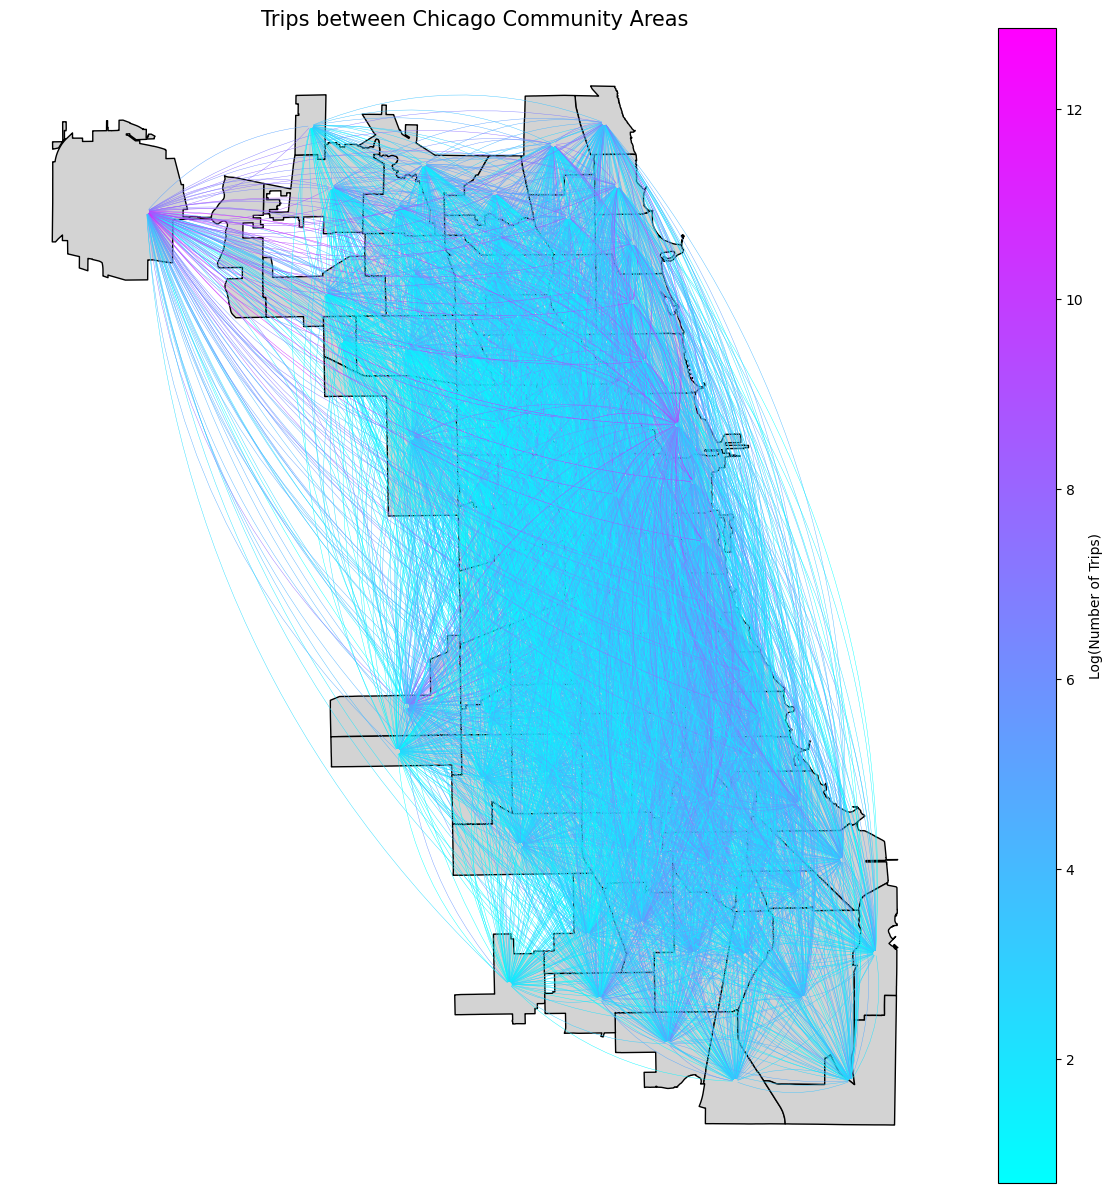

In [97]:
# Get number of trips between each pair of communities
df_taxidata_count_routes = df_taxidata
df_taxidata_count_routes = df_taxidata_count_routes.groupby(['pickup_area_number', 'dropoff_area_number']).size().reset_index(name='number_of_trips')

# Merge geometry of pickup community
df_community.rename(columns = {'dropoff_area_number':'pickup_area_number'}, inplace = True)
df_taxidata_count_routes = df_taxidata_count_routes.merge(df_community, how='left', on='pickup_area_number')
df_taxidata_count_routes.rename(columns = {'geometry':'geometry_pickup'}, inplace = True)

# Merge geometry of dropoff community
df_community.rename(columns = {'pickup_area_number':'dropoff_area_number'}, inplace = True)
df_taxidata_count_routes = df_taxidata_count_routes.merge(df_community, how='left', on='dropoff_area_number')
df_taxidata_count_routes.rename(columns = {'geometry':'geometry_dropoff'}, inplace = True)

df_taxidata_count_routes = df_taxidata_count_routes.drop('community_x', axis=1)
df_taxidata_count_routes = df_taxidata_count_routes.drop('community_y', axis=1)

# Calculate centroids for each community area for arc drawing
df_community_areas = df_community
df_community_areas = df_community_areas.to_crs(epsg=26916)
df_community_areas['centroid'] = df_community_areas.geometry.centroid

# Apply log transformation to the number of trips
df_taxidata_count_routes['log_trips'] = np.log1p(df_taxidata_count_routes['number_of_trips']) 

# Normalize the trips for color mapping
norm = mcolors.Normalize(vmin=df_taxidata_count_routes['log_trips'].min(),
                         vmax=df_taxidata_count_routes['log_trips'].max())
cmap = matplotlib.colormaps.get_cmap('cool')

# Plot the base map of community areas
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
df_community_areas.plot(ax=ax, color='lightgrey', edgecolor='black')

# Draw arcs between community areas
for i, row in df_taxidata_count_routes.iterrows():
    pickup_area = row['pickup_area_number']
    dropoff_area = row['dropoff_area_number']
    log_trips = row['log_trips']
    
    if pickup_area != dropoff_area:
        try:
            end_point = df_community_areas[df_community_areas['dropoff_area_number'] == dropoff_area]['centroid'].values[0]
        except KeyError:
            df_community_areas.rename(columns = {'pickup_area_number':'dropoff_area_number'}, inplace = True)
            end_point = df_community_areas[df_community_areas['dropoff_area_number'] == dropoff_area]['centroid'].values[0]
        try:    
            start_point = df_community_areas[df_community_areas['pickup_area_number'] == pickup_area]['centroid'].values[0]
        except KeyError:
            df_community_areas.rename(columns = {'dropoff_area_number':'pickup_area_number'}, inplace = True)
            start_point = df_community_areas[df_community_areas['pickup_area_number'] == pickup_area]['centroid'].values[0]
        
        # Convert start_point and end_point from Point objects to tuples
        start_coords = (start_point.x, start_point.y)
        end_coords = (end_point.x, end_point.y)
        
        # Use the normalized trips count to get the color from the cmap
        color = cmap(norm(log_trips))
        
        # Define arc characteristics: color and linewidth based on the number of trips
        arc = FancyArrowPatch(start_coords, end_coords, color=color, linewidth=0.3, connectionstyle="arc3,rad=0.2", arrowstyle="-")
        ax.add_patch(arc)

# Add legend
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Log(Number of Trips)')        
        
# Optional: Add a title and clean up the map
ax.set_title('Trips between Chicago Community Areas', fontsize=15)
plt.axis('off')  # Turn off the axis
plt.show()
